In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Sources List

1. What is RAPTOR - https://fivethirtyeight.com/features/how-our-raptor-metric-works/
2. Previous literature - https://link.springer.com/article/10.1007/s11031-013-9389-7
   - Main Problem: Induced bias by not including players whose last season was a contract year and didn't get signed after (positively inflates contract year effect)
   - Second problem: Inherent endogeneity in regression (better players get longer contracts and are thus less likely to be in a CY)
4. Previous literature - https://dash.harvard.edu/handle/1/14398539 (very good paper, critiques 2013 paper above)
5. Potential causes literature -  https://escholarship.org/uc/item/08f7j314 (beyond scope of this analysis)
6. Forbes Salary Explanation - https://www.forbes.com/sites/maurybrown/2016/12/14/details-of-new-nba-labor-deal-see-explosion-in-player-salaries-benefits/?sh=27d8c1a84988
7. Supermax explained - https://www.villanovalawreview.com/post/2210-simplifying-the-supermax
8. https://www.spotrac.com/nba/cap/_/year/2024/sort/cap_maximum_space
9. Seven year deals: https://basketball.realgm.com/blog/217519/The-NBAs-Final-Seven-Year-Man

I leverage the following data sources:
1. FiveThirtyEight's RAPTOR dataset with historical player impact numbers from 1977 to 2022.
2. Yearly contract salary data provided by HoopsHype. Salaries are only listed from the 1990-91 season onwards.
3. RealGM's transaction history data. This gives us the specific dates on which NBA players either sign new contracts or extensions.

# Section 1: Dataset Creation

### 1. Loading FiveThirtyEight's RAPTOR Dataset

In the era of so-called "advanced analytics" in the NBA, the Robust Algorithm using Player Tracking and On/Off Ratings (RAPTOR) was developed by the analytics publication FiveThirtyEight and is a metric that captures how front offices value a certain player. It is considered an improvement among previous catch-all player performance metrics like Box Plus-Minus (BPM), Career-Arc Regression Model Estimator with Local Optimization (CARMELO), and Player Efficienciy Rating (PER). Of course, no single statistic would be able to capture all the intricacies and nuances of playing a game of basketball, but we can use a variety of metrics to approximate player performance. As a robustness check, we regress a variety of these metrics to identify a contract year effect.

In [2]:
raptor_data = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/nba-raptor/historical_RAPTOR_by_player.csv")
raptor_data.sample(10, random_state=230)

,player_name,player_id,season,poss,mp,raptor_offense,raptor_defense,raptor_total,war_total,war_reg_season,war_playoffs,predator_offense,predator_defense,predator_total,pace_impact
7864,Rodney Hood,hoodro01,2018,3803,1876,-0.493520,-2.923881,-3.417401,-0.708965,0.078627,-0.787593,-0.057367,-1.995481,-2.052849,-0.365840
14535,Luke Ridnour,ridnolu01,2010,3618,1880,2.025155,-1.361827,0.663329,3.275629,3.175742,0.099888,1.526422,-1.067492,0.458931,0.179248
1942,Winford Boynes,boynewi01,1980,2464,1102,-1.386829,0.084819,-1.302010,0.817538,0.817538,0.000000,-1.757077,-0.274753,-2.031830,0.438277
14906,Derrick Rose,rosede01,2017,4237,2082,1.186416,-1.395056,-0.208640,2.694905,2.694905,0.000000,0.484522,-1.833859,-1.349337,-0.167887
13495,Gary Payton,paytoga01,2004,6904,3597,2.307203,0.417063,2.724266,10.046604,8.081373,1.965231,2.211550,0.751269,2.962819,-0.399095
15501,Lonnie Shelton,sheltlo01,1982,6151,2933,-0.830547,0.798026,-0.032521,4.067773,3.888343,0.179430,-0.499251,1.162262,0.663010,0.164125
11353,Xavier McDaniel,mcdanxa01,1987,7589,3559,1.520141,0.085325,1.605466,7.926271,6.905258,1.021013,1.788251,0.325757,2.114007,-0.069321
12640,Mike Newlin,newlimi01,1978,2521,1181,0.844557,-1.815494,-0.970937,1.073755,1.073755,0.000000,0.693191,-1.709278,-1.016087,0.180144
6283,Mike Glenn,glennmi01,1978,2081,947,0.465870,-1.123332,-0.657462,1.012726,1.012726,0.000000,-0.153287,-1.297107,-1.450394,0.181251
15215,Tomas Satoransky,satorto01,2019,4614,2164,0.319645,-0.550262,-0.230617,2.759417,2.759417,0.000000,-0.170902,-0.327869,-0.498772,-0.812094


In [3]:
# Filter the data since contract info is only available post 1990-91
raptor_data_filtered = raptor_data[raptor_data["season"] > 1990]
raptor_data_filtered.sample(10, random_state=230)

,player_name,player_id,season,poss,mp,raptor_offense,raptor_defense,raptor_total,war_total,war_reg_season,war_playoffs,predator_offense,predator_defense,predator_total,pace_impact
7185,Lucious Harris,harrilu01,1994,2320,1165,-2.039541,-1.290234,-3.329775,-0.345898,-0.345898,0.000000,-2.546081,-1.661881,-4.207963,0.360028
3655,Tyrone Corbin,corbity01,1993,5485,2716,0.643260,0.818994,1.462254,5.842006,5.456502,0.385504,0.499801,0.990006,1.489807,-0.165944
8841,Ervin Johnson,johnser02,2004,2484,1321,-3.450814,2.429451,-1.021364,1.185396,0.594377,0.591018,-3.474736,2.566220,-0.908517,0.439172
2763,Dexter Cambridge,cambrde01,1993,1856,885,-0.987504,-2.618540,-3.606044,-0.388150,-0.388150,0.000000,-1.733242,-2.487879,-4.221121,0.411336
4813,Jared Dudley,dudleja01,2009,2268,1155,0.580741,-0.177252,0.403489,1.855476,1.855476,0.000000,0.331165,-0.224670,0.106494,0.553743
895,Vin Baker,bakervi01,2003,1804,942,-3.358514,-0.914256,-4.272770,-0.736071,-0.736071,0.000000,-3.581868,-0.958198,-4.540066,0.530343
14623,Stanley Roberts,roberst01,1992,2309,1118,-2.126877,0.784285,-1.342592,0.811872,0.811872,0.000000,-2.004569,1.130816,-0.873754,1.106834
14292,Eldridge Recasner,recasel01,1996,2520,1283,0.995843,-2.209414,-1.213571,1.002541,1.068251,-0.065710,0.517375,-2.406903,-1.889528,-0.239597
3637,Wayne Cooper,coopewa01,1991,1606,759,-4.985438,1.679975,-3.305463,-0.217269,-0.192321,-0.024948,-5.149035,0.902125,-4.246910,0.101189
3506,Steve Colter,coltest01,1995,1421,795,-1.209744,-0.131105,-1.340849,0.571670,0.553465,0.018205,-1.750211,-0.740737,-2.490947,-0.087698


### 2. Loading HoopsHype's historical salary data

Next, we use historical salary data starting from 1990-91 from the website HoopsHype. This includes a player's nominal salary in that year as well as their real salary adjusting for inflation. Code has been commented out for runtime simplicity and has been saved and loaded as a separate csv file.

In [4]:
# def load_and_stack_nba_salaries(start_year, end_year):
#     salary_dfs = []

#     for year in range(start_year, end_year):
#         season_end_year = year + 1
#         url = f"https://hoopshype.com/salaries/players/{year}-{season_end_year}/"
        
#         try:
#             df = pd.read_html(url)[0]
            
#             # Rename salary column to 'Salary'
#             df = df.rename(columns={df.columns[2]: 'Salary', df.columns[3]: 'Real Salary'})
            
#             # Add the season column
#             df['Year'] = season_end_year
#             salary_dfs.append(df)
            
#         except Exception as e:
#             print(f"Error fetching data for season {year}-{season_end_year}: {e}")
            
#     combined_df = pd.concat(salary_dfs, ignore_index=True)
    
#     return combined_df

# # Load the NBA salaries data from 1990 to 2022
# nba_salaries_df = load_and_stack_nba_salaries(1990, 2022)

In [5]:
# nba_salaries_1994_1996 = pd.read_csv("data/NBA Salary Dataset_1994-1996.csv")
# nba_salaries_df = pd.concat([nba_salaries_df, nba_salaries_1994_1996]).sort_values("Year").drop(columns=["Unnamed: 0"])
# nba_salaries_df = nba_salaries_df.drop(columns=["Unnamed: 0"])
# nba_salaries_df

In [6]:
nba_salaries_df = pd.read_csv("data/nba_salaries_df.csv")
nba_salaries_df

,Unnamed: 0,Player,Salary,Real Salary,Year
0,0,Patrick Ewing,"$4,250,000","$9,982,396",1991
1,1,Hot Rod Williams,"$3,785,000","$8,890,204",1991
2,2,Hakeem Olajuwon,"$3,175,000","$7,457,437",1991
3,3,Charles Barkley,"$2,900,000","$6,811,517",1991
4,4,Chris Mullin,"$2,850,000","$6,694,077",1991
...,...,...,...,...,...
15199,15199,Jaime Echenique,"$53,176","$59,715",2022
15200,15200,Luca Vildoza,"$42,789","$48,051",2022
15201,15201,Zavier Simpson,"$37,223","$41,800",2022
15202,15202,Mfiondu Kabengele,"$19,186","$21,545",2022


### 3. Webscraping RealGM for transaction data for NBA players

Finally, I develop a webscraping tool using BeautifulSoup that scrapes transaction history data from the website RealGM. This tool takes several hours to run, so I have commented it out for simplicity. All data that has been scraped has been pre-loaded onto three csv files. Note that some discrepancies arise in the scraping tool. For example, because NBA player Maurice Cheeks also went by "Mo Cheeks", his name is different on the RealGM website and the HoopsHype website, and because there is no unique identifier for every player like in FiveThirtyEight's dataset, the scraper ignores players whose names do not appear in both datasets. This is a limitation of the data-generating process, and ultimately, we are able to recover the transaction history of 2,286 of the 2,811 players in the salary dataset, or about 81%.

In [7]:
# def scrape_player_info(unique_names, max_player_id=75_000):
#     player_info = []
#     transactions_df = pd.DataFrame()
#     counter = 0

#     for player_id in range(0, max_player_id + 1):
#         url = f"https://basketball.realgm.com/player/player/Summary/{player_id}"
#         r = requests.get(url)
#         soup = BeautifulSoup(r.text, 'html.parser')

#         # Attempt to scrape the player's name and position
#         try:
#             profile_text = soup.find_all('div', class_='wrapper clearfix container')[0].get_text()
#             name, position = profile_text.split('\xa0')[:2]
#             name = name.strip()
#             position = position.strip()

#             if name in unique_names:
#                 counter += 1
#                 player_info.append({'Player ID': player_id, 'Player Name': name, 'Position': position})
                
#                 # Scrape the NBA transactions table if it exists
#                 try:
#                     tables = pd.read_html(url)
#                     trans_table = next((tbl for tbl in tables if 'sign' in tbl.to_string()), None)
#                     if trans_table is not None:
#                         trans_table['Player Name'] = name
#                         trans_table['Position'] = position
#                         transactions_df = pd.concat([transactions_df, trans_table], ignore_index=True)
#                 except Exception as e:
#                     print(f"Error scraping table for player {name}: {e}")

#                 if counter == len(unique_names):
#                     break
#         except Exception as e:
#             print(f"Error scraping profile for player ID {player_id}: {e}")
    
#     return transactions_df, player_info

# # Assume 'nba_salaries_df' is your DataFrame containing salary data.
# unique_names = nba_salaries_df['Player'].unique()
# transactions_df, player_info_list = scrape_player_info(unique_names)
# transactions_df.to_csv("data/transactions_df_all.csv")

In [8]:
transactions_df_all = pd.read_csv("data/transactions_df_all.csv")
transactions_df2 = pd.read_csv("data/transactions_df_all_2.csv")
transactions_df3 = pd.read_csv("data/transactions_df_all_3.csv")
transactions_all = pd.concat([transactions_df_all, transactions_df2, transactions_df3], axis=0)
transactions_all

,Unnamed: 0,0,Player Name,Position
0,0,"Jun 28, 2007 - The Portland Trail Blazers sele...",Greg Oden,C
1,1,"Jul 1, 2007 - Greg Oden signed a multi-year co...",Greg Oden,C
2,2,"Oct 25, 2008 - The Portland Trail Blazers exer...",Greg Oden,C
3,3,"Oct 16, 2009 - The Portland Trail Blazers exer...",Greg Oden,C
4,4,"Jun 29, 2011 - The Portland Trail Blazers tend...",Greg Oden,C
...,...,...,...,...
2291,2291,"Jul 1, 2022 - Deandre Ayton, previously with t...",Deandre Ayton,C
2292,2292,"Jul 14, 2022 - Deandre Ayton signed a multi-ye...",Deandre Ayton,C
2293,2293,"Jul 14, 2022 - The Phoenix Suns matched the of...",Deandre Ayton,C
2294,2294,"Jul 18, 2022 - Deandre Ayton signed a multi-ye...",Deandre Ayton,C


In [9]:
series1 = pd.Series(nba_salaries_df["Player"].unique())
series2 = pd.Series(transactions_all["Player Name"].unique())

# Number of values in transactions_all that are not in nba_salaries_df
not_in_short = series1[~series1.isin(series2)]
len(not_in_short)

512

Creating an indicator variable for Contract Year - 1 if the player "signed" a contract in a given year in their transaction history, 0 if they did not. Also creating a variable for Year using string matching.

In [10]:
transactions_all = transactions_all.rename(columns={"Player Name": "Player"})
transactions_all['Year'] = transactions_all['0'].str.extract(r'(\d{4})')
transactions_all['Contract Year'] = transactions_all['0'].str.contains('signed').astype(int)
transactions_all = transactions_all.sort_values(by=['Player', 'Year', 'Contract Year'], ascending=[True, True, False])
transactions_all = transactions_all.drop_duplicates(subset=['Player', 'Year'], keep='first')
transactions_all

,Unnamed: 0,0,Player,Position,Year,Contract Year
17584,17584,"Sep 25, 1985 - A.C. Green signed a multi-year ...",A.C. Green,PF,1985,1
17587,17587,"Oct 6, 1989 - A.C. Green signed a multi-year c...",A.C. Green,PF,1989,1
17589,17589,"Sep 28, 1993 - A.C. Green signed a multi-year ...",A.C. Green,PF,1993,1
17592,17592,"Sep 12, 1994 - A.C. Green signed a multi-year ...",A.C. Green,PF,1994,1
17593,17593,"Dec 26, 1996 - A.C. Green was acquired by the ...",A.C. Green,PF,1996,0
...,...,...,...,...,...,...
3876,3876,"Jun 22, 2011 - Zydrunas Ilgauskas exercised a ...",Zydrunas Ilgauskas,C,2011,0
298,298,"Jul 23, 2019 - Zylan Cheatham signed a two-way...",Zylan Cheatham,SF,2019,1
302,302,"Nov 23, 2020 - Zylan Cheatham signed a multi-y...",Zylan Cheatham,SF,2020,1
308,308,"Sep 23, 2021 - Zylan Cheatham signed a contrac...",Zylan Cheatham,SF,2021,1


Creating a year column to correspond to each contract year.

In [11]:
transactions_all['Year'] = transactions_all['Year'].astype(int)
year_range = transactions_all.groupby('Player')['Year'].agg([np.min, np.max]).reset_index()
all_years = pd.DataFrame({
    "Player": np.repeat(year_range['Player'], year_range['amax'] - year_range['amin'] + 1),
    "Year": [year for _, row in year_range.iterrows() for year in range(row['amin'], row['amax'] + 1)]
})
full_df = pd.merge(all_years, transactions_all, on=["Player", "Year"], how="left")
full_df['Contract Year'] = full_df['Contract Year'].fillna(0).astype(int)
full_df['Position'] = full_df.groupby('Player')['Position'].ffill().bfill()
full_df = full_df.drop_duplicates(subset=['Player', 'Year'], keep='first')
full_df = full_df.rename(columns={"0": "Transaction"})
full_df

,Player,Year,Unnamed: 0,Transaction,Position,Contract Year
0,A.C. Green,1985,17584.0,"Sep 25, 1985 - A.C. Green signed a multi-year ...",PF,1
1,A.C. Green,1986,NaN,NaN,PF,0
2,A.C. Green,1987,NaN,NaN,PF,0
3,A.C. Green,1988,NaN,NaN,PF,0
4,A.C. Green,1989,17587.0,"Oct 6, 1989 - A.C. Green signed a multi-year c...",PF,1
...,...,...,...,...,...,...
29870,Zydrunas Ilgauskas,2011,3876.0,"Jun 22, 2011 - Zydrunas Ilgauskas exercised a ...",C,0
29871,Zylan Cheatham,2019,298.0,"Jul 23, 2019 - Zylan Cheatham signed a two-way...",SF,1
29872,Zylan Cheatham,2020,302.0,"Nov 23, 2020 - Zylan Cheatham signed a multi-y...",SF,1
29873,Zylan Cheatham,2021,308.0,"Sep 23, 2021 - Zylan Cheatham signed a contrac...",SF,1


Merging transactions and salary data

In [12]:
full_df_filtered = full_df[["Player", "Year", "Position", "Contract Year"]]
merged_df = pd.merge(
    full_df_filtered,
    nba_salaries_df,
    left_on=['Player', 'Year'],
    right_on=['Player', 'Year'],
    how='inner'  # Change to 'inner' to keep only matching rows
)
merged_df

,Player,Year,Position,Contract Year,Unnamed: 0,Salary,Real Salary
0,A.C. Green,1991,PF,0,33,"$1,750,000","$4,110,398"
1,A.C. Green,1992,PF,0,407,"$1,750,000","$3,926,034"
2,A.C. Green,1993,PF,1,822,"$1,750,000","$3,808,421"
3,A.C. Green,1994,PF,1,1229,"$1,885,000","$3,982,897"
4,A.C. Green,1995,PF,0,1524,"$6,472,600","$13,343,571"
...,...,...,...,...,...,...,...
13181,Zydrunas Ilgauskas,2010,C,1,8420,"$11,541,074","$16,325,451"
13182,Zydrunas Ilgauskas,2011,C,0,9141,"$1,352,181","$1,892,792"
13183,Zylan Cheatham,2020,SF,1,13954,"$79,568","$94,778"
13184,Zylan Cheatham,2021,SF,1,14418,"$1,445,697","$1,711,017"


Merging Salary and RAPTOR data.

In [13]:
all_data_merged = pd.merge(
    raptor_data_filtered,
    merged_df,
    left_on=['player_name', 'season'],
    right_on=['Player', 'Year'],
    how='inner'  # Change to 'inner' to keep only matching rows
)

all_data_merged["Position"] = all_data_merged["Position"].str.split('\n').str[0]
all_data_merged = all_data_merged.drop(columns=["Unnamed: 0"])
all_data_merged

,player_name,player_id,season,poss,mp,raptor_offense,raptor_defense,raptor_total,war_total,war_reg_season,...,predator_offense,predator_defense,predator_total,pace_impact,Player,Year,Position,Contract Year,Salary,Real Salary
0,Alaa Abdelnaby,abdelal01,1991,640,303,-3.938450,-0.510076,-4.448526,-0.265191,-0.226163,...,-3.905732,-1.696796,-5.602528,0.199241,Alaa Abdelnaby,1991,PF,0,"$395,000","$927,775"
1,Alaa Abdelnaby,abdelal01,1992,1998,959,-2.553849,-0.197943,-2.751792,-0.006893,0.070322,...,-2.499576,-0.721876,-3.221452,0.485436,Alaa Abdelnaby,1992,PF,0,"$494,000","$1,108,263"
2,Alaa Abdelnaby,abdelal01,1993,2754,1379,-2.373736,-2.069808,-4.443544,-1.227189,-0.845272,...,-2.328144,-2.002263,-4.330407,0.488266,Alaa Abdelnaby,1993,PF,0,"$500,000","$1,088,120"
3,Alaa Abdelnaby,abdelal01,1994,320,159,-6.140056,-2.748312,-8.888368,-0.500600,-0.500600,...,-5.820936,-3.526560,-9.347496,0.511152,Alaa Abdelnaby,1994,PF,1,"$805,000","$1,700,919"
4,Alaa Abdelnaby,abdelal01,1995,984,506,-3.846543,-1.268012,-5.114556,-0.615802,-0.615802,...,-3.715429,-1.027024,-4.742453,1.545922,Alaa Abdelnaby,1995,PF,1,"$650,000","$1,340,005"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12491,Ivica Zubac,zubaciv01,2018,871,410,-2.903709,2.688832,-0.214877,0.531968,0.531968,...,-2.616331,0.752875,-1.863456,0.311576,Ivica Zubac,2018,C,1,"$1,312,611","$1,634,951"
12492,Ivica Zubac,zubaciv01,2019,2345,1079,-2.362444,1.813768,-0.548676,1.217134,1.114995,...,-2.810283,1.157824,-1.652459,0.077074,Ivica Zubac,2019,C,1,"$1,544,951","$1,870,631"
12493,Ivica Zubac,zubaciv01,2020,3447,1646,1.099849,3.549458,4.649308,6.224207,5.020903,...,-0.310842,3.331974,3.021132,-0.410164,Ivica Zubac,2020,C,0,"$6,481,482","$7,720,525"
12494,Ivica Zubac,zubaciv01,2021,3908,1910,-0.909039,2.525735,1.616696,4.261327,3.704630,...,-0.874338,2.280011,1.405673,-0.117623,Ivica Zubac,2021,C,0,"$7,000,000","$8,284,669"


For the purpose of this analysis, we simplify the position coding process to account for heavy variation and fluidity in an individual player's position. We create "Guards", "Wings", and "Bigs" as catch-all categories. While this potentially ignores some nuance in the position a player plays, the old method for coding players includes far too much variation. This keeps each player's position consistent throughout their career.

In [14]:
position_map = {
    "G": "G",
    "C": "C",
    "F": "F",
    "PF": "F",
    "SG": "G",
    "SF": "F",
    "PG": "G",
    "FC": "F",
    "GF": "G",
    "F-C": "F",
    "G-F": "G",
    "C-F": "C",
    "F-G": "F"
}

# Apply the mapping to the Position column
all_data_merged['Position'] = all_data_merged['Position'].map(position_map)
all_data_merged["Position"].value_counts()

Position
F    5430
G    5167
C    1899
Name: count, dtype: int64

### 4. Merging with Basketball Reference

Basketball Reference is an online database that contains yearly NBA player and team statistics dating back to the very first season in 1947. We leverage these databases to get NBA player counting stats from 1991 to 2022. Note that player teams coded as `TOT` indicate that the player played on several teams over the course of that season, and those statistics represent the aggregate across multiple teams.

In [15]:
import pandas as pd

def fetch_nba_stats(start_year, end_year):
    all_data = []

    for year in range(start_year, end_year + 1):
        print(f'Processing year: {year}')
        # File paths for different types of stats
        file_paths = {
            'per_game': f"data/{year}/pergame_{year}.csv",
            'per_100': f"data/{year}/per100poss_{year}.csv",
            'advanced': f"data/{year}/advanced_{year}.csv"
        }

        # Load data from CSV files
        year_data = {}
        for stat_type, file_path in file_paths.items():
            df = pd.read_csv(file_path)
            # Standardize column names for easier merging
            df.columns = [col.replace('%', 'Pct') for col in df.columns]
            df = df[df['Rk'] != 'Rk']  # Remove repeated header rows
            df['Year'] = year  # Add year column
            year_data[stat_type] = df

        # Handling the 'TOT' condition for players with multiple teams in a year
        # We keep only rows where 'Tm' is 'TOT' if 'TOT' exists for that player that year
        tot_players = year_data['per_game'][year_data['per_game']['Tm'] == 'TOT']['Player']
        for player in tot_players.unique():
            for stat_type in year_data:
                df = year_data[stat_type]
                df = df[(df['Player'] != player) | (df['Tm'] == 'TOT')]
                year_data[stat_type] = df

        # Merge all data types horizontally based on 'Player', 'Year', and 'Pos'
        df_merged = year_data['per_game']
        df_merged = df_merged.merge(year_data['per_100'], on=['Player', 'Year', 'Pos'], suffixes=('', '_per_100'))
        df_merged = df_merged.merge(year_data['advanced'], on=['Player', 'Year', 'Pos'], suffixes=('', '_adv'))

        # Append the merged data to all_data list
        all_data.append(df_merged)

    # Concatenate all yearly DataFrames into a single DataFrame
    final_df = pd.concat(all_data, ignore_index=True)
    return final_df

# Usage example: Fetch data from 1991 to 2022
nba_stats_df = fetch_nba_stats(1991, 2022)
nba_stats_df = nba_stats_df.dropna(axis=1)
nba_stats_df = nba_stats_df.drop(columns={"Rk", "Rk_per_100", "Age_per_100", "Tm_per_100", "G_per_100", "GS_per_100",
                                          "MP_per_100", "Player-additional_per_100", "Rk_adv", "Age_adv", "Tm_adv", "G_adv",
                                          "MP_adv", "Player-additional_adv"})
nba_stats_df
nba_stats_df

Processing year: 1991
Processing year: 1992
Processing year: 1993
Processing year: 1994
Processing year: 1995
Processing year: 1996
Processing year: 1997
Processing year: 1998
Processing year: 1999
Processing year: 2000
Processing year: 2001
Processing year: 2002
Processing year: 2003
Processing year: 2004
Processing year: 2005
Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
Processing year: 2021
Processing year: 2022


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,3P,...,PTS,Player-additional,Year,OWS,DWS,WS,OBPM,DBPM,BPM,VORP
0,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,2.7,0.0,...,3.1,abdelal01,1991,0.0,0.5,0.5,-3.4,-1.2,-4.6,-0.2
1,Mahmoud Abdul-Rauf,PG,21,DEN,67,19,22.5,6.2,15.1,0.4,...,14.1,abdulma02,1991,-0.7,-0.3,-1.0,-2.0,-3.0,-5.0,-1.1
2,Mark Acres,C,28,ORL,68,0,19.3,1.6,3.1,0.0,...,4.2,acresma01,1991,1.4,1.1,2.5,-2.8,-0.2,-3.0,-0.3
3,Michael Adams,PG,28,DEN,66,66,35.5,8.5,21.5,2.5,...,26.5,adamsmi01,1991,5.8,0.4,6.3,6.0,-0.7,5.3,4.3
4,Mark Aguirre,SF,31,DET,78,13,25.7,5.4,11.7,0.3,...,14.2,aguirma01,1991,2.8,2.7,5.5,1.2,0.2,1.4,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14708,Thaddeus Young,PF,33,TOT,52,1,16.3,2.7,5.2,0.3,...,6.2,youngth01,2022,0.9,1.3,2.2,0.1,2.1,2.2,0.9
14709,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,3.1,...,28.4,youngtr01,2022,9.0,1.0,10.0,7.1,-2.0,5.2,4.8
14710,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.0,...,5.3,yurtsom01,2022,0.8,1.4,2.1,-1.4,0.4,-1.0,0.2
14711,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,0.0,...,5.2,zelleco01,2022,0.9,0.2,1.1,-1.2,-1.0,-2.1,0.0


Now we can merge the datasets together.

In [16]:
nba_stats_df = nba_stats_df.rename(columns={'Player-additional': 'player_id', 'Year': 'season'})

# Merge the DataFrames on 'player_name' and 'season'
all_data_merged = pd.merge(nba_stats_df, all_data_merged, on=['player_id', 'season'])
all_data_merged = all_data_merged.dropna()
all_data_merged = all_data_merged.rename(columns={"G": "GP"})
all_data_merged

,Player_x,Pos,Age,Tm,GP,GS,MP,FG,FGA,3P,...,predator_offense,predator_defense,predator_total,pace_impact,Player_y,Year,Position,Contract Year,Salary,Real Salary
0,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,2.7,0.0,...,-3.905732,-1.696796,-5.602528,0.199241,Alaa Abdelnaby,1991,F,0,"$395,000","$927,775"
1,Mahmoud Abdul-Rauf,PG,21,DEN,67,19,22.5,6.2,15.1,0.4,...,-2.808590,-2.762224,-5.570814,0.206361,Mahmoud Abdul-Rauf,1991,G,0,"$1,660,000","$3,899,006"
2,Mark Acres,C,28,ORL,68,0,19.3,1.6,3.1,0.0,...,-2.408789,0.404661,-2.004128,0.435896,Mark Acres,1991,F,1,"$437,000","$1,026,425"
3,Michael Adams,PG,28,DEN,66,66,35.5,8.5,21.5,2.5,...,6.151354,-0.759427,5.391927,0.336374,Michael Adams,1991,G,0,"$825,000","$1,937,759"
4,Mark Aguirre,SF,31,DET,78,13,25.7,5.4,11.7,0.3,...,1.252788,-0.091098,1.161691,0.242006,Mark Aguirre,1991,F,0,"$1,115,000","$2,618,910"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12491,Delon Wright,SG,29,ATL,77,8,18.9,1.6,3.5,0.6,...,-0.343431,2.104946,1.761516,-1.497641,Delon Wright,2022,G,1,"$8,526,316","$9,574,876"
12492,Thaddeus Young,PF,33,TOT,52,1,16.3,2.7,5.2,0.3,...,-0.490506,1.012304,0.521798,0.412187,Thaddeus Young,2022,F,1,"$14,190,000","$15,935,077"
12493,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.0,...,-2.256519,0.176608,-2.079910,-0.035254,Omer Yurtseven,2022,C,0,"$1,489,065","$1,672,189"
12494,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,0.0,...,-0.396488,-2.401036,-2.797523,0.312001,Cody Zeller,2022,F,1,"$2,389,641","$2,683,517"


In [17]:
# all_data_merged.to_csv("data/all_data_merged.csv")

### 5. Exploratory Data Analysis

We can first analyze how NBA salaries have changed over time, both in nominal terms and adjusted for inflation.

In [18]:
def convert_currency(val):
    """
    Convert the string number value to a float
     - Remove $
     - Remove commas
     - Convert to float type
    """
    new_val = val.replace(',', '').replace('$', '')
    if new_val[0] == "-":
        return -1 * float(new_val[1:])
    return float(new_val)

In [19]:
# Apply this function to the Salary and Real Salary columns
all_data_merged['Salary'] = all_data_merged['Salary'].apply(convert_currency)
all_data_merged['Real Salary'] = all_data_merged['Real Salary'].apply(convert_currency)
all_data_merged

,Player_x,Pos,Age,Tm,GP,GS,MP,FG,FGA,3P,...,predator_offense,predator_defense,predator_total,pace_impact,Player_y,Year,Position,Contract Year,Salary,Real Salary
0,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,2.7,0.0,...,-3.905732,-1.696796,-5.602528,0.199241,Alaa Abdelnaby,1991,F,0,395000.0,927775.0
1,Mahmoud Abdul-Rauf,PG,21,DEN,67,19,22.5,6.2,15.1,0.4,...,-2.808590,-2.762224,-5.570814,0.206361,Mahmoud Abdul-Rauf,1991,G,0,1660000.0,3899006.0
2,Mark Acres,C,28,ORL,68,0,19.3,1.6,3.1,0.0,...,-2.408789,0.404661,-2.004128,0.435896,Mark Acres,1991,F,1,437000.0,1026425.0
3,Michael Adams,PG,28,DEN,66,66,35.5,8.5,21.5,2.5,...,6.151354,-0.759427,5.391927,0.336374,Michael Adams,1991,G,0,825000.0,1937759.0
4,Mark Aguirre,SF,31,DET,78,13,25.7,5.4,11.7,0.3,...,1.252788,-0.091098,1.161691,0.242006,Mark Aguirre,1991,F,0,1115000.0,2618910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12491,Delon Wright,SG,29,ATL,77,8,18.9,1.6,3.5,0.6,...,-0.343431,2.104946,1.761516,-1.497641,Delon Wright,2022,G,1,8526316.0,9574876.0
12492,Thaddeus Young,PF,33,TOT,52,1,16.3,2.7,5.2,0.3,...,-0.490506,1.012304,0.521798,0.412187,Thaddeus Young,2022,F,1,14190000.0,15935077.0
12493,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.0,...,-2.256519,0.176608,-2.079910,-0.035254,Omer Yurtseven,2022,C,0,1489065.0,1672189.0
12494,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,0.0,...,-0.396488,-2.401036,-2.797523,0.312001,Cody Zeller,2022,F,1,2389641.0,2683517.0


Let's look at how median salaries have changed over time in the NBA in both nominal and real terms.

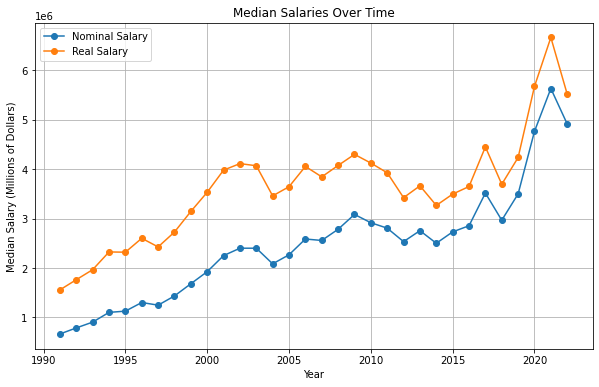

In [20]:
median_salaries = all_data_merged.groupby('Year')[['Salary', 'Real Salary']].median()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(median_salaries.index, median_salaries['Salary'], label='Nominal Salary', marker='o')
plt.plot(median_salaries.index, median_salaries['Real Salary'], label='Real Salary', marker='o')
plt.title('Median Salaries Over Time')
plt.xlabel('Year')
plt.ylabel('Median Salary (Millions of Dollars)')
plt.legend()
plt.grid(True)
plt.show()

We can take a look at median salaries in terms of 4-year windows as well.

In [21]:
bins = list(range(1991, 2023 + 1, 4))  # Extending to 2023 to include 2022 in the last bin
labels = [f'{i}-{i+3}' for i in bins[:-1]]  # Labels for the bins
merged_data_salary_analysis = all_data_merged.copy()
merged_data_salary_analysis['Period'] = pd.cut(merged_data_salary_analysis['Year'], bins=bins, labels=labels, right=False)
window_median_salaries = merged_data_salary_analysis.groupby('Period')[['Salary', 'Real Salary']].median()
print(window_median_salaries)

              Salary  Real Salary
Period                           
1991-1994   845000.0    1882448.0
1995-1998  1297500.0    2534189.0
1999-2002  2000428.0    3671588.0
2003-2006  2392500.0    3842058.0
2007-2010  2765900.0    4044527.0
2011-2014  2626473.0    3499518.0
2015-2018  2996390.0    3794854.0
2019-2022  4767000.0    5631382.0


We can now focus on growth in median salaries themselves.

In [22]:
growth_nominal = ((median_salaries.loc[2022, 'Salary'] / median_salaries.loc[1991, 'Salary']) - 1) * 100
growth_real = ((median_salaries.loc[2022, 'Real Salary'] / median_salaries.loc[1991, 'Real Salary']) - 1) * 100

print(f'Growth in Nominal Salary: {growth_nominal:.2f}%')
print(f'Growth in Real Salary: {growth_real:.2f}%')

Growth in Nominal Salary: 642.06%
Growth in Real Salary: 254.79%


And in four year windows.

In [23]:
window_growth = window_median_salaries.pct_change() * 100

print(window_growth)

              Salary  Real Salary
Period                           
1991-1994        NaN          NaN
1995-1998  53.550296    34.621992
1999-2002  54.175568    44.882169
2003-2006  19.599406     4.642950
2007-2010  15.607106     5.269806
2011-2014  -5.040927   -13.475222
2015-2018  14.084173     8.439334
2019-2022  59.091440    48.395222


Clearly something happened between 2015 and 2019. This was due to the new CBA in 2016 that allowed for larger contracts than ever before and the introduction of "supermax" contracts for star players.

We can generate summary statistics for 1991 and 2022.

In [24]:
# Generate descriptive statistics for 1991 and 2022
stats_1991 = all_data_merged[all_data_merged['Year'] == 1991][['Salary', 'Real Salary']].describe()
stats_2022 = all_data_merged[all_data_merged['Year'] == 2022][['Salary', 'Real Salary']].describe()

In [25]:
stats_1991

,Salary,Real Salary
count,3.380000e+02,3.380000e+02
mean,8.435740e+05,1.981385e+06
std,6.678501e+05,1.568646e+06
min,3.000000e+04,7.046300e+04
25%,3.612500e+05,8.485030e+05
50%,6.625000e+05,1.556078e+06
75%,1.100000e+06,2.583678e+06
max,4.250000e+06,9.982396e+06


In [26]:
stats_2022

,Salary,Real Salary
count,2.510000e+02,2.510000e+02
mean,9.520251e+06,1.069104e+07
std,1.070138e+07,1.201743e+07
min,3.722300e+04,4.180000e+04
25%,1.785938e+06,2.005572e+06
50%,4.916160e+06,5.520746e+06
75%,1.370833e+07,1.539418e+07
max,4.578097e+07,5.141108e+07


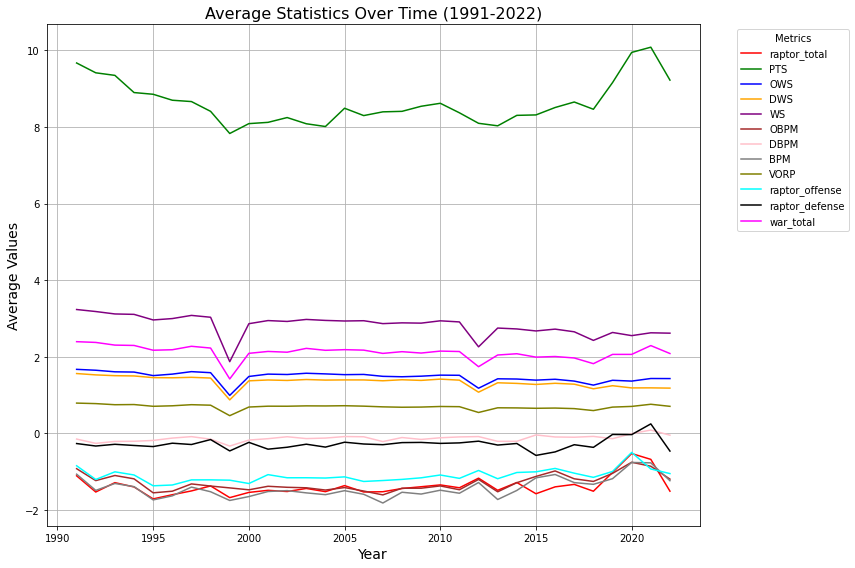

In [27]:
annual_means = all_data_merged.groupby("Year")[[
    'raptor_total', 'PTS', 'OWS', 'DWS', 'WS', 'OBPM', 
    'DBPM', 'BPM', 'VORP', 'raptor_offense', 'raptor_defense', 'war_total'
]].mean()
colors = [
    'red', 'green', 'blue', 'orange', 'purple',
    'brown', 'pink', 'gray', 'olive', 'cyan',
    'black', 'magenta', 'yellow', 'lime', 'maroon',
    'navy', 'teal', 'coral', 'gold', 'lightblue',
    'darkgreen', 'lavender', 'turquoise', 'tan', 'salmon',
    'beige', 'mustard', 'mint', 'sienna', 'fuchsia'
]
# Plot each statistic over years
plt.figure(figsize=(12, 8))
for i in range(len(annual_means.columns)):
    plt.plot(annual_means.index, annual_means[annual_means.columns[i]], label=annual_means.columns[i], color=colors[i])

plt.title('Average Statistics Over Time (1991-2022)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Values', fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='Metrics')
plt.grid(True)
plt.tight_layout()
plt.show()

### 6. Bias Reduction For Post-Contract Year Performance - A Machine Learning Application

Ryan (2015) correctly points out that there is an induced bias in point estimates for how contract years affect performance in post-contract year seasons. If players do not get re-signed after their contract year, effectively "dropping out" of the dataset, their play was likely negative and would have probably even continued declining if they signed a new contract. So, any estimates that use our set-up of comparing performance in a contract year vs. the season immediately after would be inherently upwardly biased towards finding an effect.

To circumvent this issue, we explore an application of predictive modeling to impute values for a hypothetical "last season" for players whose last active playing year was a contract year, but did not receive a new contract subequently and were out of the league the next season. We impute with the following methods:
1. A naive imputation method where all counting stats are set to 0 (or, for player statistics that can take negative values, the minimum of that player's statistical category across their career). These estimates are far too conservative, and as such should not be taken as even believable estimates of how that player would have performed the following season. Rather, they serve as a "worst-case" lower-bound on player performance to deflate the upwardly-biased point estimate in their absence.
2. A naive imputation method where we keep the player's statistics from their final year to their imputed final year exactly the same. The corresponding estimate for the contract year's association with performance would assume that "drop-out" players would have done no worse than their last season. This itself is a bit of a strong assumption since players tend to consistently decline in their last few seasons, but still is able deflate what would otherwise be an upwardly biased estimate.
3. Using predictive linear models to predict a player's performance metrics based on lagged values of their statistics from previous years and other covariates. This way, we would actually be able to forecast reasonable declines in player performance. We cross-validate our imputation method by detecting its error in imputing players' performances whose next-season statistics are known.

#### Method 1 and 2: Naive Imputation (Zero Imputation and Constant Imputation)

In [28]:
last_seasons = all_data_merged.groupby('player_id').last().reset_index()
new_rows_zero = last_seasons.copy()

# Adjust the year and age
new_rows_zero['Year'] += 1
new_rows_zero['Age'] += 1
new_rows_zero['season'] += 1

# Define the columns to be zeroed out
counting_stats_columns = ['GP', 'GS', 'MP', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
advanced_stats_columns = ['OWS', 'DWS', 'WS', 'OBPM', 'DBPM', 'BPM', 'VORP', 'raptor_offense', 'raptor_defense', 'raptor_total', 'war_total', 'war_reg_season', 'war_playoffs', 'predator_offense', 'predator_defense', 'predator_total', 'pace_impact']

min_values = all_data_merged.groupby('player_id')[counting_stats_columns + advanced_stats_columns].min().applymap(lambda x: min(0, x))
new_rows_zero[counting_stats_columns + advanced_stats_columns] = 0
for col in counting_stats_columns + advanced_stats_columns:
    # Map the minimum values for each player to the new rows, applying the min(0, x) condition
    new_rows_zero[col] = new_rows_zero['player_id'].map(min_values[col])

new_rows_zero["Contract Year"] = 0
df_zero_imputed = pd.concat([all_data_merged, new_rows_zero], ignore_index=True)

In [29]:
df_zero_imputed[df_zero_imputed["Player_y"] == "Cody Zeller"].iloc[:, :32]

,Player_x,Pos,Age,Tm,GP,GS,MP,FG,FGA,3P,...,PF,PTS,player_id,season,OWS,DWS,WS,OBPM,DBPM,BPM
9473,Cody Zeller,C,21,CHA,82,3,17.3,2.1,4.9,0.0,...,2.1,6.0,zelleco01,2014,0.4,2.2,2.6,-2.9,0.9,-2.0
9915,Cody Zeller,C,22,CHO,62,45,24.0,2.8,6.0,0.0,...,2.5,7.6,zelleco01,2015,1.6,2.2,3.8,-2.0,1.4,-0.6
10344,Cody Zeller,C,23,CHO,73,60,24.3,3.2,6.0,0.0,...,2.8,8.7,zelleco01,2016,3.6,2.7,6.3,-1.1,1.0,-0.1
10774,Cody Zeller,C,24,CHO,62,58,27.8,4.1,7.1,0.0,...,3.0,10.3,zelleco01,2017,3.4,2.2,5.6,-0.9,1.1,0.2
11236,Cody Zeller,C,25,CHO,33,0,19.0,2.6,4.7,0.1,...,2.5,7.1,zelleco01,2018,1.2,0.7,1.9,-1.2,0.0,-1.2
11644,Cody Zeller,C,26,CHO,49,47,25.4,3.9,7.0,0.1,...,3.3,10.1,zelleco01,2019,2.6,1.2,3.9,-0.6,0.7,0.1
11959,Cody Zeller,C,27,CHO,58,39,23.1,4.3,8.3,0.3,...,2.4,11.1,zelleco01,2020,2.3,1.3,3.6,0.2,-0.8,-0.6
12242,Cody Zeller,C,28,CHO,48,21,20.9,3.8,6.8,0.1,...,2.5,9.4,zelleco01,2021,2.1,1.1,3.3,-0.2,-0.2,-0.5
12493,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,0.0,...,2.1,5.2,zelleco01,2022,0.9,0.2,1.1,-1.2,-1.0,-2.1
14644,Cody Zeller,C,30,POR,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,zelleco01,2023,0.0,0.0,0.0,-2.9,-1.0,-2.1


In [30]:
new_rows_const = all_data_merged.copy()
last_rows_const = new_rows_const.groupby('player_id').last().reset_index()
last_rows_const['Year'] += 1
last_rows_const['Age'] += 1
last_rows_const['season'] += 1
last_rows_const['Contract Year'] = 0
df_const_imputed = pd.concat([all_data_merged, last_rows_const], ignore_index=True)

In [31]:
df_const_imputed[df_const_imputed["Player_x"] == "Cody Zeller"].iloc[:, :32]

,Player_x,Pos,Age,Tm,GP,GS,MP,FG,FGA,3P,...,PF,PTS,player_id,season,OWS,DWS,WS,OBPM,DBPM,BPM
9473,Cody Zeller,C,21,CHA,82,3,17.3,2.1,4.9,0.0,...,2.1,6.0,zelleco01,2014,0.4,2.2,2.6,-2.9,0.9,-2.0
9915,Cody Zeller,C,22,CHO,62,45,24.0,2.8,6.0,0.0,...,2.5,7.6,zelleco01,2015,1.6,2.2,3.8,-2.0,1.4,-0.6
10344,Cody Zeller,C,23,CHO,73,60,24.3,3.2,6.0,0.0,...,2.8,8.7,zelleco01,2016,3.6,2.7,6.3,-1.1,1.0,-0.1
10774,Cody Zeller,C,24,CHO,62,58,27.8,4.1,7.1,0.0,...,3.0,10.3,zelleco01,2017,3.4,2.2,5.6,-0.9,1.1,0.2
11236,Cody Zeller,C,25,CHO,33,0,19.0,2.6,4.7,0.1,...,2.5,7.1,zelleco01,2018,1.2,0.7,1.9,-1.2,0.0,-1.2
11644,Cody Zeller,C,26,CHO,49,47,25.4,3.9,7.0,0.1,...,3.3,10.1,zelleco01,2019,2.6,1.2,3.9,-0.6,0.7,0.1
11959,Cody Zeller,C,27,CHO,58,39,23.1,4.3,8.3,0.3,...,2.4,11.1,zelleco01,2020,2.3,1.3,3.6,0.2,-0.8,-0.6
12242,Cody Zeller,C,28,CHO,48,21,20.9,3.8,6.8,0.1,...,2.5,9.4,zelleco01,2021,2.1,1.1,3.3,-0.2,-0.2,-0.5
12493,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,0.0,...,2.1,5.2,zelleco01,2022,0.9,0.2,1.1,-1.2,-1.0,-2.1
14644,Cody Zeller,C,30,POR,27,0,13.1,1.9,3.3,0.0,...,2.1,5.2,zelleco01,2023,0.9,0.2,1.1,-1.2,-1.0,-2.1


#### Method 3: Imputation with Machine Learning

In [32]:
lagged_data = all_data_merged.copy()

all_statistics = counting_stats_columns + advanced_stats_columns + ["Salary"]
for lag in [1, 2, 3]:
    for stat in all_statistics:
        lagged_data[f'{stat}_lag_{lag}'] = lagged_data.groupby('player_id')[f'{stat}'].shift(lag)
        
# Fill missing values that are created by lagging
lagged_data = lagged_data.fillna(method='bfill')
lagged_data

,Player_x,Pos,Age,Tm,GP,GS,MP,FG,FGA,3P,...,raptor_defense_lag_3,raptor_total_lag_3,war_total_lag_3,war_reg_season_lag_3,war_playoffs_lag_3,predator_offense_lag_3,predator_defense_lag_3,predator_total_lag_3,pace_impact_lag_3,Salary_lag_3
0,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,2.7,0.0,...,-0.510076,-4.448526,-0.265191,-0.226163,-0.039028,-3.905732,-1.696796,-5.602528,0.199241,395000.0
1,Mahmoud Abdul-Rauf,PG,21,DEN,67,19,22.5,6.2,15.1,0.4,...,-0.510076,-4.448526,-0.265191,-0.226163,-0.039028,-3.905732,-1.696796,-5.602528,0.199241,395000.0
2,Mark Acres,C,28,ORL,68,0,19.3,1.6,3.1,0.0,...,-0.510076,-4.448526,-0.265191,-0.226163,-0.039028,-3.905732,-1.696796,-5.602528,0.199241,395000.0
3,Michael Adams,PG,28,DEN,66,66,35.5,8.5,21.5,2.5,...,-0.510076,-4.448526,-0.265191,-0.226163,-0.039028,-3.905732,-1.696796,-5.602528,0.199241,395000.0
4,Mark Aguirre,SF,31,DET,78,13,25.7,5.4,11.7,0.3,...,-0.510076,-4.448526,-0.265191,-0.226163,-0.039028,-3.905732,-1.696796,-5.602528,0.199241,395000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12491,Delon Wright,SG,29,ATL,77,8,18.9,1.6,3.5,0.6,...,2.004639,2.486914,4.504779,4.504779,0.000000,-0.119078,2.254856,2.135778,-0.800096,2536898.0
12492,Thaddeus Young,PF,33,TOT,52,1,16.3,2.7,5.2,0.3,...,1.887133,2.553316,7.052930,6.364636,0.688294,0.599050,2.677257,3.276307,-0.873491,13764045.0
12493,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.0,...,0.551004,1.015305,2.395152,2.395152,0.000000,0.277617,0.640045,0.917661,0.310521,13528090.0
12494,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,0.0,...,0.551004,1.015305,2.395152,2.395152,0.000000,0.277617,0.640045,0.917661,0.310521,13528090.0


In [33]:
features = lagged_data.drop(columns=["Player_x", "Pos", "Tm", "player_id", "season", "player_name", "poss", "mp", "Player_y", "Real Salary"])

I applied data preprocessing on the features to create dummies for the `Position` column and standardize the numeric features by year.

In [34]:
from sklearn.preprocessing import StandardScaler

# Assuming 'features' is your DataFrame
# Create dummy variables for the 'Position' column
position_dummies = pd.get_dummies(features['Position'], drop_first=True)

# Concatenate the dummy variables with the original dataframe and drop the 'Position' column
features = pd.concat([features, position_dummies], axis=1)
features = features.drop('Position', axis=1)

features["F"] = features["F"].astype(int)
features["G"] = features["G"].astype(int)
features["AgeSq"] = features["Age"] ** 2

# Standardize Columns
exclude_columns = ["Year", "Contract Year", "F", "G"]
features_to_scale = features.drop(columns=exclude_columns)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_scale)
scaled_features_df = pd.DataFrame(scaled_features, columns=features_to_scale.columns, index=features_to_scale.index)
features_standardized = pd.concat([scaled_features_df, features[exclude_columns]], axis=1)
features_standardized

,Age,GP,GS,MP,FG,FGA,3P,3PA,2P,2PA,...,predator_offense_lag_3,predator_defense_lag_3,predator_total_lag_3,pace_impact_lag_3,Salary_lag_3,AgeSq,Year,Contract Year,F,G
0,-1.186645,-0.504974,-0.929051,-1.434792,-0.864744,-0.947706,-0.807354,-0.875475,-0.684906,-0.720930,...,-1.198811,-0.865143,-1.302124,0.188487,-0.738440,-1.105905,1991,0,1,0
1,-1.424027,0.503588,-0.283899,0.143476,1.341483,1.704927,-0.222320,-0.043008,1.617893,2.034240,...,-1.198811,-0.865143,-1.302124,0.188487,-0.738440,-1.286935,1991,0,0,1
2,0.237648,0.545612,-0.929051,-0.176173,-0.729669,-0.862137,-0.807354,-0.875475,-0.534724,-0.619822,...,-1.198811,-0.865143,-1.302124,0.188487,-0.738440,0.157093,1991,1,1,0
3,0.237648,0.461565,1.312004,1.442051,2.377059,3.074028,2.849110,3.841840,1.667954,1.882580,...,-1.198811,-0.865143,-1.302124,0.188487,-0.738440,0.157093,1991,0,0,1
4,0.949795,0.965846,-0.487631,0.463125,0.981283,0.977592,-0.368579,-0.320497,1.217406,1.301213,...,-1.198811,-0.865143,-1.302124,0.188487,-0.738440,0.902262,1991,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12491,0.475030,0.923823,-0.657408,-0.216129,-0.729669,-0.776569,0.070197,-0.043008,-0.835089,-0.897867,...,0.207583,1.473149,0.846412,-1.547352,-0.292233,0.397063,2022,1,0,1
12492,1.424559,-0.126763,-0.895096,-0.475844,-0.234393,-0.412901,-0.368579,-0.375995,-0.134237,-0.316501,...,0.474301,1.723095,1.163079,-1.674838,2.046638,1.441142,2022,1,1,0
12493,-0.949263,0.041331,-0.521587,-0.845439,-0.414493,-0.584039,-0.807354,-0.764480,-0.184298,-0.341778,...,0.354918,0.517625,0.508202,0.381780,1.997483,-0.916455,2022,0,0,0
12494,0.475030,-1.177349,-0.929051,-0.795494,-0.594594,-0.819353,-0.807354,-0.819978,-0.384541,-0.594546,...,0.354918,0.517625,0.508202,0.381780,1.997483,0.397063,2022,1,1,0


In [35]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

target_columns = [
    'GP', 'GS', 'MP', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB',
    'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'OWS', 'DWS', 'WS', 'OBPM', 'DBPM',
    'BPM', 'VORP', 'raptor_offense', 'raptor_defense', 'raptor_total', 'war_total',
    'war_reg_season', 'war_playoffs', 'predator_offense', 'predator_defense',
    'predator_total', 'pace_impact'
]

# Store results
results = []

# Iterate through each target variable
for target in target_columns:
    # Define the features and target
    X = features_standardized.drop(columns=target_columns)  # Drop all potential target columns from features
    y = features_standardized[target]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize the Linear Regression model
    models = {
        'OLS': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'LASSO': Lasso(alpha=0.01),
        'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5),
    }
    
    for name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
            
        # Predict on the testing set
        y_pred = model.predict(X_test)
        
        # Calculate MSE
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        # Append the results
        results.append({'Target': target, 'Model': name, 'RMSE': np.sqrt(mse), 'MAE': mae, 'Original SD': np.std(y)})

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

In [36]:
mean_metrics = results_df.groupby('Model')[['RMSE', 'MAE']].mean()

print(results_df)
print("\nMean RMSE and MAE for each model:\n", mean_metrics)

             Target       Model      RMSE       MAE  Original SD
0                GP         OLS  0.908196  0.740514          1.0
1                GP       Ridge  0.907034  0.740094          1.0
2                GP       LASSO  0.907418  0.746124          1.0
3                GP  ElasticNet  0.905595  0.742753          1.0
4                GS         OLS  0.812014  0.637032          1.0
..              ...         ...       ...       ...          ...
143  predator_total  ElasticNet  0.869996  0.562877          1.0
144     pace_impact         OLS  0.952893  0.600623          1.0
145     pace_impact       Ridge  0.951590  0.598528          1.0
146     pace_impact       LASSO  0.957074  0.598583          1.0
147     pace_impact  ElasticNet  0.954457  0.596981          1.0

[148 rows x 5 columns]

Mean RMSE and MAE for each model:
                 RMSE       MAE
Model                         
ElasticNet  0.737887  0.508305
LASSO       0.740506  0.510269
OLS         0.738278  0.510616
Ridge

In [37]:
print(results_df.to_string())

               Target       Model      RMSE       MAE  Original SD
0                  GP         OLS  0.908196  0.740514          1.0
1                  GP       Ridge  0.907034  0.740094          1.0
2                  GP       LASSO  0.907418  0.746124          1.0
3                  GP  ElasticNet  0.905595  0.742753          1.0
4                  GS         OLS  0.812014  0.637032          1.0
5                  GS       Ridge  0.810791  0.635786          1.0
6                  GS       LASSO  0.810340  0.638865          1.0
7                  GS  ElasticNet  0.808743  0.636020          1.0
8                  MP         OLS  0.721506  0.572416          1.0
9                  MP       Ridge  0.720412  0.571635          1.0
10                 MP       LASSO  0.723902  0.576896          1.0
11                 MP  ElasticNet  0.720991  0.573496          1.0
12                 FG         OLS  0.634983  0.478371          1.0
13                 FG       Ridge  0.634085  0.477475         

Our Elastic Net model and Ridge Model have comparable performance for prediction. We will proceed with the Elastic Net model for imputing hypothetical following-year performances.

In [38]:
counting_stats_columns = ['GP', 'GS', 'MP', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
advanced_stats_columns = ['OWS', 'DWS', 'WS', 'OBPM', 'DBPM', 'BPM', 'VORP', 'raptor_offense', 'raptor_defense', 'raptor_total', 'war_total', 'war_reg_season', 'war_playoffs', 'predator_offense', 'predator_defense', 'predator_total', 'pace_impact']

lagged_data = all_data_merged.copy()

all_statistics = counting_stats_columns + advanced_stats_columns + ["Salary"]
for lag in [1, 2, 3]:
    for stat in all_statistics:
        lagged_data[f'{stat}_lag_{lag}'] = lagged_data.groupby('player_id')[f'{stat}'].shift(lag)
        
# Fill missing values that are created by lagging
lagged_data = lagged_data.fillna(method='bfill')
last_seasons = lagged_data.groupby('player_id').last().reset_index()
last_contract_year = last_seasons[last_seasons['Contract Year'] == 1]

# Create new rows for prediction, simulating the next year
new_rows = last_contract_year.copy()
new_rows['Age'] += 1
new_rows['season'] += 1
new_rows['Year'] += 1

# Shift the lag columns correctly
for stat in counting_stats_columns + advanced_stats_columns + ['Salary']:
    new_rows[f'{stat}_lag_3'] = lagged_data[f'{stat}_lag_2']
    new_rows[f'{stat}_lag_2'] = lagged_data[f'{stat}_lag_1']
    new_rows[f'{stat}_lag_1'] = lagged_data[stat]

new_rows = new_rows.drop(columns=["Player_x", "Pos", "Tm", "player_id", "season", "player_name", "poss", "mp", "Player_y", "Real Salary"])
new_rows_position_dummies = pd.get_dummies(new_rows['Position'], drop_first=True)
new_rows = pd.concat([new_rows, new_rows_position_dummies], axis=1)
new_rows = new_rows.drop('Position', axis=1)
new_rows["F"] = new_rows["F"].astype(int)
new_rows["G"] = new_rows["G"].astype(int)
new_rows["AgeSq"] = new_rows["Age"] ** 2
exclude_columns = ["Year", "Contract Year", "F", "G"]
new_rows_to_scale = new_rows.drop(columns=exclude_columns)
scaler = StandardScaler()
scaled_new_rows = scaler.fit_transform(new_rows_to_scale)
scaled_new_rows_df = pd.DataFrame(scaled_new_rows, columns=new_rows_to_scale.columns, index=new_rows_to_scale.index)
new_rows_standardized = pd.concat([scaled_new_rows_df, new_rows[exclude_columns]], axis=1)

# Same target columns as before
target_columns = [
    'GP', 'GS', 'MP', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB',
    'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'OWS', 'DWS', 'WS', 'OBPM', 'DBPM',
    'BPM', 'VORP', 'raptor_offense', 'raptor_defense', 'raptor_total', 'war_total',
    'war_reg_season', 'war_playoffs', 'predator_offense', 'predator_defense',
    'predator_total', 'pace_impact'
]

for target in target_columns:

    # First fit an elastic net model on entire dataset to learn parameters:
    X = features_standardized.drop(columns=target_columns)  # Drop all potential target columns from features
    y = features_standardized[target]
    model = ElasticNet(alpha=0.01, l1_ratio=0.5)
    model.fit(X, y)
    
    new_rows_X = new_rows_standardized.drop(columns=target_columns)
    new_rows_preds = model.predict(new_rows_X)
    new_rows_standardized[target] = new_rows_preds

In [39]:
# Invert our Standardization to original units

original_features = scaler.inverse_transform(scaled_new_rows_df)
original_features_df = pd.DataFrame(original_features, columns=scaled_new_rows_df.columns, index=scaled_new_rows_df.index)
full_original_df = pd.concat([original_features_df, new_rows_standardized[exclude_columns]], axis=1)
new_rows = full_original_df.copy()
new_rows["Contract Year"] = 0
new_rows

,Age,GP,GS,MP,FG,FGA,3P,3PA,2P,2PA,...,predator_offense_lag_3,predator_defense_lag_3,predator_total_lag_3,pace_impact_lag_3,Salary_lag_3,AgeSq,Year,Contract Year,F,G
0,27.0,54.0,0.0,9.4,2.2,4.3,0.0,0.0,2.2,4.2,...,-3.905732,-1.696796,-5.602528,0.199241,395000.0,729.0,1996,0,1,0
5,27.0,25.0,0.0,8.0,1.2,3.0,0.3,0.8,0.9,2.2,...,-3.905732,-1.696796,-5.602528,0.199241,395000.0,729.0,2010,0,0,1
6,31.0,18.0,7.0,14.9,1.4,2.7,0.1,0.1,1.4,2.6,...,-3.905732,-1.696796,-5.602528,0.199241,395000.0,961.0,1994,0,1,0
7,29.0,10.0,0.0,12.3,0.4,1.8,0.2,1.5,0.2,0.3,...,-3.905732,-1.696796,-5.602528,0.199241,395000.0,841.0,2020,0,1,0
11,29.0,76.0,75.0,26.3,2.8,5.1,0.0,0.0,2.8,5.0,...,-3.905732,-1.696796,-5.602528,0.199241,395000.0,841.0,2023,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2151,31.0,2.0,0.0,2.0,0.5,2.0,0.0,0.0,0.5,2.0,...,4.182776,2.225816,6.408592,0.014123,2100000.0,961.0,2021,0,0,0
2152,25.0,12.0,0.0,5.3,0.6,2.4,0.1,0.2,0.5,2.3,...,-2.582980,-0.020850,-2.603830,0.398578,845000.0,625.0,1999,0,0,0
2153,21.0,19.0,0.0,5.7,0.5,1.6,0.0,0.0,0.5,1.6,...,2.110015,0.420015,2.530030,-0.884164,1125000.0,441.0,2018,0,0,0
2154,24.0,54.0,12.0,15.3,1.5,4.3,0.7,2.0,0.8,2.3,...,-3.297072,2.210151,-1.086921,-0.159721,3510000.0,576.0,2019,0,1,0


#### Assembling the datasets

In [40]:
missing_columns = set(last_contract_year.columns) - set(new_rows.columns)
for col in missing_columns:
    new_rows[col] = last_contract_year[col]

# Concatenate the dataframes
combined_df = pd.concat([last_contract_year, new_rows], ignore_index=True)

# Sort by player_id
combined_df = combined_df.sort_values(by='player_id')

# Display or return the result
combined_df

,player_id,Player_x,Pos,Age,Tm,GP,GS,MP,FG,FGA,...,war_reg_season_lag_3,war_playoffs_lag_3,predator_offense_lag_3,predator_defense_lag_3,predator_total_lag_3,pace_impact_lag_3,Salary_lag_3,AgeSq,F,G
0,abdelal01,Alaa Abdelnaby,PF,26.0,TOT,54.0,0.0,9.4,2.2,4.3,...,0.070322,-0.077215,-2.499576,-0.721876,-3.221452,0.485436,494000.0,NaN,NaN,NaN
963,abdelal01,Alaa Abdelnaby,PF,27.0,TOT,54.0,0.0,9.4,2.2,4.3,...,-0.226163,-0.039028,-3.905732,-1.696796,-5.602528,0.199241,395000.0,729.0,1.0,0.0
1,ackeral01,Alex Acker,SG,26.0,TOT,25.0,0.0,8.0,1.2,3.0,...,0.002884,-0.096072,-3.748247,-0.105089,-3.853336,0.122785,1670000.0,NaN,NaN,NaN
964,ackeral01,Alex Acker,SG,27.0,TOT,25.0,0.0,8.0,1.2,3.0,...,-0.226163,-0.039028,-3.905732,-1.696796,-5.602528,0.199241,395000.0,729.0,0.0,1.0
2,acresma01,Mark Acres,C,30.0,TOT,18.0,7.0,14.9,1.4,2.7,...,-0.226163,-0.039028,-3.905732,-1.696796,-5.602528,0.199241,395000.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,zimmest01,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,5.7,0.5,1.6,...,-0.083313,0.000000,-2.797224,-1.648024,-4.445248,-0.100454,915243.0,NaN,NaN,NaN
1924,zipsepa01,Paul Zipser,SF,24.0,CHI,54.0,12.0,15.3,1.5,4.3,...,1.791050,0.000000,-3.297072,2.210151,-1.086921,-0.159721,3510000.0,576.0,1.0,0.0
961,zipsepa01,Paul Zipser,SF,23.0,CHI,54.0,12.0,15.3,1.5,4.3,...,1.123479,0.000000,-1.406108,0.021970,-1.384138,-0.102988,981348.0,NaN,NaN,NaN
962,zubaciv01,Ivica Zubac,C,24.0,LAC,76.0,76.0,24.4,4.1,6.5,...,1.114995,0.102138,-2.810283,1.157824,-1.652459,0.077074,1544951.0,NaN,NaN,NaN


In [41]:
columns_to_keep = all_data_merged.columns
combined_df_filtered = combined_df[columns_to_keep]
df_ml_imputed = pd.concat([all_data_merged, combined_df_filtered], ignore_index=True).drop_duplicates(ignore_index=True)
df_ml_imputed = df_ml_imputed[df_ml_imputed["Year"] != 2023]
df_ml_imputed

,Player_x,Pos,Age,Tm,GP,GS,MP,FG,FGA,3P,...,predator_offense,predator_defense,predator_total,pace_impact,Player_y,Year,Position,Contract Year,Salary,Real Salary
0,Alaa Abdelnaby,PF,22.0,POR,43.0,0.0,6.7,1.3,2.7,0.0,...,-3.905732,-1.696796,-5.602528,0.199241,Alaa Abdelnaby,1991,F,0,395000.0,927775.0
1,Mahmoud Abdul-Rauf,PG,21.0,DEN,67.0,19.0,22.5,6.2,15.1,0.4,...,-2.808590,-2.762224,-5.570814,0.206361,Mahmoud Abdul-Rauf,1991,G,0,1660000.0,3899006.0
2,Mark Acres,C,28.0,ORL,68.0,0.0,19.3,1.6,3.1,0.0,...,-2.408789,0.404661,-2.004128,0.435896,Mark Acres,1991,F,1,437000.0,1026425.0
3,Michael Adams,PG,28.0,DEN,66.0,66.0,35.5,8.5,21.5,2.5,...,6.151354,-0.759427,5.391927,0.336374,Michael Adams,1991,G,0,825000.0,1937759.0
4,Mark Aguirre,SF,31.0,DET,78.0,13.0,25.7,5.4,11.7,0.3,...,1.252788,-0.091098,1.161691,0.242006,Mark Aguirre,1991,F,0,1115000.0,2618910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13446,Sam Young,SG,28.0,IND,56.0,3.0,12.4,1.0,2.6,0.3,...,-3.312925,-1.030755,-4.343680,0.326738,Sam Young,2014,F,0,761319.0,1012233.0
13449,Tyler Zeller,C,31.0,SAS,2.0,0.0,2.0,0.5,2.0,0.0,...,5.147975,6.618079,11.766054,-0.775088,Tyler Zeller,2021,C,0,245686.0,292652.0
13450,George Zídek,C,25.0,TOT,12.0,0.0,5.3,0.6,2.4,0.1,...,-7.397329,-4.289575,-11.686904,0.689432,George Zidek,1999,C,0,784200.0,1492616.0
13451,Stephen Zimmerman,C,21.0,ORL,19.0,0.0,5.7,0.5,1.6,0.0,...,-3.003926,-7.264944,-10.268870,-0.538247,Stephen Zimmerman,2018,C,0,950000.0,1202622.0


In [42]:
df_zero_imputed = df_zero_imputed[df_zero_imputed["Year"] != 2023].drop_duplicates(ignore_index=True)
df_zero_imputed

,Player_x,Pos,Age,Tm,GP,GS,MP,FG,FGA,3P,...,predator_offense,predator_defense,predator_total,pace_impact,Player_y,Year,Position,Contract Year,Salary,Real Salary
0,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,2.7,0.0,...,-3.905732,-1.696796,-5.602528,0.199241,Alaa Abdelnaby,1991,F,0,395000.0,927775.0
1,Mahmoud Abdul-Rauf,PG,21,DEN,67,19,22.5,6.2,15.1,0.4,...,-2.808590,-2.762224,-5.570814,0.206361,Mahmoud Abdul-Rauf,1991,G,0,1660000.0,3899006.0
2,Mark Acres,C,28,ORL,68,0,19.3,1.6,3.1,0.0,...,-2.408789,0.404661,-2.004128,0.435896,Mark Acres,1991,F,1,437000.0,1026425.0
3,Michael Adams,PG,28,DEN,66,66,35.5,8.5,21.5,2.5,...,6.151354,-0.759427,5.391927,0.336374,Michael Adams,1991,G,0,825000.0,1937759.0
4,Mark Aguirre,SF,31,DET,78,13,25.7,5.4,11.7,0.3,...,1.252788,-0.091098,1.161691,0.242006,Mark Aguirre,1991,F,0,1115000.0,2618910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14392,Tyler Zeller,C,31,SAS,0,0,0.0,0.0,0.0,0.0,...,-3.509643,-0.989833,-4.122921,-0.775088,Tyler Zeller,2021,C,0,245686.0,292652.0
14393,George Zídek,C,25,TOT,0,0,0.0,0.0,0.0,0.0,...,-7.397329,-4.289575,-11.686904,0.000000,George Zidek,1999,C,0,784200.0,1492616.0
14394,Stephen Zimmerman,C,21,ORL,0,0,0.0,0.0,0.0,0.0,...,-3.003926,-7.264944,-10.268870,-0.538247,Stephen Zimmerman,2018,C,0,950000.0,1202622.0
14395,Paul Zipser,SF,24,CHI,0,0,0.0,0.0,0.0,0.0,...,-4.125170,-1.510538,-5.514792,-0.645897,Paul Zipser,2019,F,0,1312611.0,1634951.0


In [43]:
df_const_imputed = df_const_imputed[df_const_imputed["Year"] != 2023].drop_duplicates(ignore_index=True)
df_const_imputed

,Player_x,Pos,Age,Tm,GP,GS,MP,FG,FGA,3P,...,predator_offense,predator_defense,predator_total,pace_impact,Player_y,Year,Position,Contract Year,Salary,Real Salary
0,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,2.7,0.0,...,-3.905732,-1.696796,-5.602528,0.199241,Alaa Abdelnaby,1991,F,0,395000.0,927775.0
1,Mahmoud Abdul-Rauf,PG,21,DEN,67,19,22.5,6.2,15.1,0.4,...,-2.808590,-2.762224,-5.570814,0.206361,Mahmoud Abdul-Rauf,1991,G,0,1660000.0,3899006.0
2,Mark Acres,C,28,ORL,68,0,19.3,1.6,3.1,0.0,...,-2.408789,0.404661,-2.004128,0.435896,Mark Acres,1991,F,1,437000.0,1026425.0
3,Michael Adams,PG,28,DEN,66,66,35.5,8.5,21.5,2.5,...,6.151354,-0.759427,5.391927,0.336374,Michael Adams,1991,G,0,825000.0,1937759.0
4,Mark Aguirre,SF,31,DET,78,13,25.7,5.4,11.7,0.3,...,1.252788,-0.091098,1.161691,0.242006,Mark Aguirre,1991,F,0,1115000.0,2618910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14392,Tyler Zeller,C,31,SAS,2,0,2.0,0.5,2.0,0.0,...,5.147975,6.618079,11.766054,-0.775088,Tyler Zeller,2021,C,0,245686.0,292652.0
14393,George Zídek,C,25,TOT,12,0,5.3,0.6,2.4,0.1,...,-7.397329,-4.289575,-11.686904,0.689432,George Zidek,1999,C,0,784200.0,1492616.0
14394,Stephen Zimmerman,C,21,ORL,19,0,5.7,0.5,1.6,0.0,...,-3.003926,-7.264944,-10.268870,-0.538247,Stephen Zimmerman,2018,C,0,950000.0,1202622.0
14395,Paul Zipser,SF,24,CHI,54,12,15.3,1.5,4.3,0.7,...,-4.125170,-1.389621,-5.514792,-0.645897,Paul Zipser,2019,F,0,1312611.0,1634951.0


In [44]:
all_data_merged = all_data_merged.drop_duplicates(ignore_index=True)
all_data_merged

,Player_x,Pos,Age,Tm,GP,GS,MP,FG,FGA,3P,...,predator_offense,predator_defense,predator_total,pace_impact,Player_y,Year,Position,Contract Year,Salary,Real Salary
0,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,2.7,0.0,...,-3.905732,-1.696796,-5.602528,0.199241,Alaa Abdelnaby,1991,F,0,395000.0,927775.0
1,Mahmoud Abdul-Rauf,PG,21,DEN,67,19,22.5,6.2,15.1,0.4,...,-2.808590,-2.762224,-5.570814,0.206361,Mahmoud Abdul-Rauf,1991,G,0,1660000.0,3899006.0
2,Mark Acres,C,28,ORL,68,0,19.3,1.6,3.1,0.0,...,-2.408789,0.404661,-2.004128,0.435896,Mark Acres,1991,F,1,437000.0,1026425.0
3,Michael Adams,PG,28,DEN,66,66,35.5,8.5,21.5,2.5,...,6.151354,-0.759427,5.391927,0.336374,Michael Adams,1991,G,0,825000.0,1937759.0
4,Mark Aguirre,SF,31,DET,78,13,25.7,5.4,11.7,0.3,...,1.252788,-0.091098,1.161691,0.242006,Mark Aguirre,1991,F,0,1115000.0,2618910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12486,Delon Wright,SG,29,ATL,77,8,18.9,1.6,3.5,0.6,...,-0.343431,2.104946,1.761516,-1.497641,Delon Wright,2022,G,1,8526316.0,9574876.0
12487,Thaddeus Young,PF,33,TOT,52,1,16.3,2.7,5.2,0.3,...,-0.490506,1.012304,0.521798,0.412187,Thaddeus Young,2022,F,1,14190000.0,15935077.0
12488,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.0,...,-2.256519,0.176608,-2.079910,-0.035254,Omer Yurtseven,2022,C,0,1489065.0,1672189.0
12489,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,0.0,...,-0.396488,-2.401036,-2.797523,0.312001,Cody Zeller,2022,F,1,2389641.0,2683517.0


In [45]:
df_zero_imputed[df_zero_imputed["Player_x"] == "Paul Zipser"]

,Player_x,Pos,Age,Tm,GP,GS,MP,FG,FGA,3P,...,predator_offense,predator_defense,predator_total,pace_impact,Player_y,Year,Position,Contract Year,Salary,Real Salary
10773,Paul Zipser,SF,22,CHI,44,18,19.2,2.0,5.0,0.8,...,-2.467834,-1.510538,-3.978372,-0.160355,Paul Zipser,2017,F,1,750000.0,949438.0
11234,Paul Zipser,SF,23,CHI,54,12,15.3,1.5,4.3,0.7,...,-4.125170,-1.389621,-5.514792,-0.645897,Paul Zipser,2018,F,1,1312611.0,1634951.0
14395,Paul Zipser,SF,24,CHI,0,0,0.0,0.0,0.0,0.0,...,-4.125170,-1.510538,-5.514792,-0.645897,Paul Zipser,2019,F,0,1312611.0,1634951.0


# Section 2: Modeling

### 1. Summary Statistics

In [46]:
dep_vars = ["raptor_total", "PTS", "OWS", "DWS", "WS", "OBPM", "DBPM", "BPM", "VORP", "raptor_offense", "raptor_defense", "war_total"]
for var in dep_vars:
    print(var)
    print(all_data_merged[var].describe())
    print("=====")

raptor_total
count    12491.000000
mean        -1.389076
std          4.098012
min        -63.749646
25%         -3.400026
50%         -1.241531
75%          0.876895
max         47.473611
Name: raptor_total, dtype: float64
=====
PTS
count    12491.000000
mean         8.585958
std          6.046243
min          0.000000
25%          3.900000
50%          7.100000
75%         12.000000
max         36.100000
Name: PTS, dtype: float64
=====
OWS
count    12491.000000
mean         1.471395
std          2.124430
min         -3.300000
25%          0.000000
50%          0.800000
75%          2.300000
max         14.900000
Name: OWS, dtype: float64
=====
DWS
count    12491.000000
mean         1.346538
std          1.235426
min         -1.000000
25%          0.400000
50%          1.000000
75%          2.000000
max          9.100000
Name: DWS, dtype: float64
=====
WS
count    12491.000000
mean         2.818758
std          3.052127
min         -2.100000
25%          0.400000
50%          1.900000

In [47]:
players_in_cy_by_year = all_data_merged[["Year", "Contract Year"]].groupby("Year").mean()
players_in_cy_by_year

,Contract Year
Year,
1991,0.286982
1992,0.290698
1993,0.263456
1994,0.349711
1995,0.290859
1996,0.363636
1997,0.354331
1998,0.041131
1999,0.669312


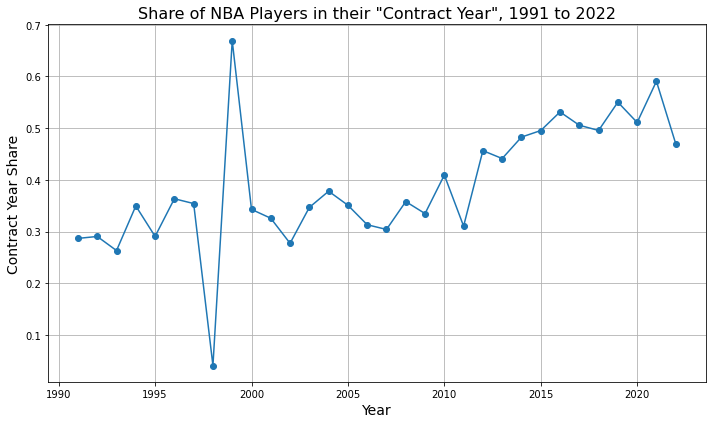

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(players_in_cy_by_year.index, players_in_cy_by_year['Contract Year'], marker='o', linestyle='-')

# Adding title and labels with specific font sizes
plt.title('Share of NBA Players in their "Contract Year", 1991 to 2022', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Contract Year Share', fontsize=14)

# Adding grid for better readability
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [49]:
year_windows = [(1991, 1994), (1995, 1998), (1999, 2002), (2003, 2006), (2007, 2010),
                (2011, 2014), (2015, 2018), (2019, 2022)]


window_averages = pd.DataFrame(columns=['Start Year', 'End Year', 'Average Contract Year'])
for start, end in year_windows:
    window_data = all_data_merged[(all_data_merged['Year'] >= start) & (all_data_merged['Year'] <= end)]
    mean_value = window_data['Contract Year'].mean()
    add_row = pd.DataFrame({
        'Start Year': [start],
        'End Year': [end],
        'Average Contract Year': [mean_value]
    })
    # Append the results to the DataFrame using pd.concat
    window_averages = pd.concat([window_averages, add_row], ignore_index=True)

# Display the resulting averages
window_averages

,Start Year,End Year,Average Contract Year
0,1991,1994,0.297610
1,1995,1998,0.261214
2,1999,2002,0.399624
3,2003,2006,0.346939
4,2007,2010,0.351090
5,2011,2014,0.424313
6,2015,2018,0.506795
7,2019,2022,0.533493


### 2. Do players perform better in their contract year?

The first thing we are interested in knowing is the change in expected performance that comes with being in a contract year. If we regress player performance on a dummy variable indicating whether that player is in a contract year or not, i.e.:

$$\text{Performance}_{i, t} = \beta_0 + \beta_1 \text{Contract Year}_{i, t} + \gamma^T \textbf{X} + \epsilon_{it}$$

where $\textbf{X}$ is a matrix of covariates, then a positive $\beta_1$ would show that relative to players not in a contract year, players in a contract year have a greater expected performance; and conversely, a negative $\beta_1$ would show that players in a contract year have a worse expected performance compared to those not in a contract year. Starting with `raptor_total` as our measure of player performance, we estimate the simple regression without covariates below:

In [50]:
import statsmodels.api as sm

X = all_data_merged[["Contract Year"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["raptor_total"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           raptor_total   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     90.09
Date:                Fri, 10 May 2024   Prob (F-statistic):           2.68e-21
Time:                        21:31:01   Log-Likelihood:                -35294.
No. Observations:               12491   AIC:                         7.059e+04
Df Residuals:                   12489   BIC:                         7.061e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.1015      0.044    -25.290

Contrary to what we might have expected, on average, players' performance as measured by `raptor_total` actually *decreases* in their contract year. We can change the dependent variable to see which metrics see an increase.

In [51]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["PTS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     487.9
Date:                Fri, 10 May 2024   Prob (F-statistic):          4.26e-106
Time:                        21:31:01   Log-Likelihood:                -39974.
No. Observations:               12491   AIC:                         7.995e+04
Df Residuals:                   12489   BIC:                         7.997e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.4993      0.071    133.383

In [52]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["OWS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    OWS   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     240.3
Date:                Fri, 10 May 2024   Prob (F-statistic):           1.05e-53
Time:                        21:31:01   Log-Likelihood:                -27026.
No. Observations:               12491   AIC:                         5.406e+04
Df Residuals:                   12489   BIC:                         5.407e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.6958      0.026     65.833

In [53]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["DWS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    DWS   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     423.7
Date:                Fri, 10 May 2024   Prob (F-statistic):           1.28e-92
Time:                        21:31:01   Log-Likelihood:                -20169.
No. Observations:               12491   AIC:                         4.034e+04
Df Residuals:                   12489   BIC:                         4.036e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.5200      0.015    103.375

In [54]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["WS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     364.7
Date:                Fri, 10 May 2024   Prob (F-statistic):           3.76e-80
Time:                        21:31:01   Log-Likelihood:                -31493.
No. Observations:               12491   AIC:                         6.299e+04
Df Residuals:                   12489   BIC:                         6.301e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.2166      0.036     88.194

In [55]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["OBPM"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   OBPM   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     142.0
Date:                Fri, 10 May 2024   Prob (F-statistic):           1.47e-32
Time:                        21:31:01   Log-Likelihood:                -32901.
No. Observations:               12491   AIC:                         6.581e+04
Df Residuals:                   12489   BIC:                         6.582e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.0074      0.037    -27.442

In [56]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["DBPM"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   DBPM   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.98
Date:                Fri, 10 May 2024   Prob (F-statistic):           0.000925
Time:                        21:31:01   Log-Likelihood:                -22947.
No. Observations:               12491   AIC:                         4.590e+04
Df Residuals:                   12489   BIC:                         4.591e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0903      0.016     -5.758

In [57]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["BPM"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    BPM   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     122.7
Date:                Fri, 10 May 2024   Prob (F-statistic):           2.20e-28
Time:                        21:31:01   Log-Likelihood:                -35180.
No. Observations:               12491   AIC:                         7.036e+04
Df Residuals:                   12489   BIC:                         7.038e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.0979      0.043    -25.542

In [58]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["VORP"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   VORP   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     192.8
Date:                Fri, 10 May 2024   Prob (F-statistic):           1.63e-43
Time:                        21:31:01   Log-Likelihood:                -22004.
No. Observations:               12491   AIC:                         4.401e+04
Df Residuals:                   12489   BIC:                         4.403e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8256      0.017     47.282

In [59]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["raptor_offense"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         raptor_offense   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     83.07
Date:                Fri, 10 May 2024   Prob (F-statistic):           9.11e-20
Time:                        21:31:01   Log-Likelihood:                -32087.
No. Observations:               12491   AIC:                         6.418e+04
Df Residuals:                   12489   BIC:                         6.419e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.8952      0.034    -26.385

In [60]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["raptor_defense"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         raptor_defense   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     17.87
Date:                Fri, 10 May 2024   Prob (F-statistic):           2.38e-05
Time:                        21:31:01   Log-Likelihood:                -28113.
No. Observations:               12491   AIC:                         5.623e+04
Df Residuals:                   12489   BIC:                         5.625e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2063      0.022     -9.177

In [61]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["war_total"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              war_total   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     218.0
Date:                Fri, 10 May 2024   Prob (F-statistic):           6.53e-49
Time:                        21:31:01   Log-Likelihood:                -33577.
No. Observations:               12491   AIC:                         6.716e+04
Df Residuals:                   12489   BIC:                         6.717e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.4633      0.044     56.161

Contrary to the intuition of the popular "contract year" narrative, across every single player performance metric, NBA players perform *worse* in their contract year, not better! There could be several reasons for this. For one, the vast majority of NBA players are, to put it simply, not star players. Out of the 15 players on an NBA roster, only 8 to 10 are regularly playing in the rotation, and of those 8 to 10, perhaps 3 to 5 would be good enough to start on every other team in the league.

I introduce controls for minutes played and possessions to see how it affects the point estimate for being in a contract year.

In [62]:
X = all_data_merged[["Contract Year", "mp"]] # Add control for minutes played
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["raptor_total"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           raptor_total   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     1834.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -33109.
No. Observations:               12491   AIC:                         6.622e+04
Df Residuals:                   12488   BIC:                         6.625e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.7403      0.080    -59.563

In [63]:
X = all_data_merged[["Contract Year", "poss"]] # Add control for minutes played
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["raptor_total"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           raptor_total   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     1824.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -33110.
No. Observations:               12491   AIC:                         6.623e+04
Df Residuals:                   12488   BIC:                         6.625e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.7413      0.080    -59.497

In [64]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "mp"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["PTS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     9615.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -33708.
No. Observations:               12491   AIC:                         6.742e+04
Df Residuals:                   12488   BIC:                         6.744e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.7468      0.061     28.461

In [65]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "poss"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["PTS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     9913.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -33542.
No. Observations:               12491   AIC:                         6.709e+04
Df Residuals:                   12488   BIC:                         6.711e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.6852      0.061     27.730

In [66]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "mp"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["OWS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    OWS   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     4148.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -22018.
No. Observations:               12491   AIC:                         4.404e+04
Df Residuals:                   12488   BIC:                         4.406e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.8701      0.023    -37.698

In [67]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "poss"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["OWS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    OWS   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     4130.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -22059.
No. Observations:               12491   AIC:                         4.412e+04
Df Residuals:                   12488   BIC:                         4.415e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.8641      0.023    -37.552

In [68]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "mp"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["DWS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    DWS   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     6882.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -13613.
No. Observations:               12491   AIC:                         2.723e+04
Df Residuals:                   12488   BIC:                         2.725e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0888      0.011     -8.342

In [69]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "poss"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["DWS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    DWS   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     6693.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -13831.
No. Observations:               12491   AIC:                         2.767e+04
Df Residuals:                   12488   BIC:                         2.769e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0739      0.011     -6.901

In [70]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "mp"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["WS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     8487.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -23688.
No. Observations:               12491   AIC:                         4.738e+04
Df Residuals:                   12488   BIC:                         4.740e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.9565      0.026    -36.308

In [71]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "poss"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["WS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     8251.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -23853.
No. Observations:               12491   AIC:                         4.771e+04
Df Residuals:                   12488   BIC:                         4.773e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.9356      0.026    -35.347

In [72]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "mp"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["OBPM"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   OBPM   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     2305.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -30229.
No. Observations:               12491   AIC:                         6.046e+04
Df Residuals:                   12488   BIC:                         6.049e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.2700      0.064    -66.494

In [73]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "poss"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["DBPM"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   DBPM   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     149.4
Date:                Fri, 10 May 2024   Prob (F-statistic):           7.66e-65
Time:                        21:31:02   Log-Likelihood:                -22754.
No. Observations:               12491   AIC:                         4.551e+04
Df Residuals:                   12488   BIC:                         4.554e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5248      0.033    -16.110

In [74]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "mp"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["BPM"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    BPM   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     1898.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -32849.
No. Observations:               12491   AIC:                         6.570e+04
Df Residuals:                   12488   BIC:                         6.573e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.8027      0.079    -60.441

In [75]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "poss"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["BPM"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    BPM   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     1888.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -32846.
No. Observations:               12491   AIC:                         6.570e+04
Df Residuals:                   12488   BIC:                         6.572e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.8057      0.080    -60.375

In [76]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "mp"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["VORP"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   VORP   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     2664.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -18051.
No. Observations:               12491   AIC:                         3.611e+04
Df Residuals:                   12488   BIC:                         3.613e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.7574      0.018    -42.603

In [77]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "poss"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["VORP"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   VORP   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     2645.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -18097.
No. Observations:               12491   AIC:                         3.620e+04
Df Residuals:                   12488   BIC:                         3.622e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.7512      0.018    -42.361

In [78]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "mp"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["raptor_offense"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         raptor_offense   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     1821.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -29912.
No. Observations:               12491   AIC:                         5.983e+04
Df Residuals:                   12488   BIC:                         5.985e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.7047      0.061    -60.981

In [79]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "poss"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["raptor_offense"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         raptor_offense   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     1830.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -29897.
No. Observations:               12491   AIC:                         5.980e+04
Df Residuals:                   12488   BIC:                         5.982e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.7143      0.061    -61.089

In [80]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "mp"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["raptor_defense"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         raptor_defense   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     237.6
Date:                Fri, 10 May 2024   Prob (F-statistic):          5.08e-102
Time:                        21:31:02   Log-Likelihood:                -27803.
No. Observations:               12491   AIC:                         5.561e+04
Df Residuals:                   12488   BIC:                         5.564e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.0355      0.049    -21.149

In [81]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "poss"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["raptor_defense"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         raptor_defense   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     231.6
Date:                Fri, 10 May 2024   Prob (F-statistic):           1.81e-99
Time:                        21:31:02   Log-Likelihood:                -27810.
No. Observations:               12491   AIC:                         5.563e+04
Df Residuals:                   12488   BIC:                         5.565e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.0270      0.049    -20.955

In [82]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "mp"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["war_total"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              war_total   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     3403.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:02   Log-Likelihood:                -28768.
No. Observations:               12491   AIC:                         5.754e+04
Df Residuals:                   12488   BIC:                         5.756e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.8145      0.042    -42.782

In [83]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}
X = all_data_merged[["Contract Year", "poss"]]
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["war_total"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              war_total   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     3361.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:03   Log-Likelihood:                -28831.
No. Observations:               12491   AIC:                         5.767e+04
Df Residuals:                   12488   BIC:                         5.769e+04
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.7974      0.042    -42.385

Our main finding is that that while aggregate metrics do improve in a contract year when controlling for minutes played and possessions, the factor driving this is offensive aggregate metrics, which consistently see an increase in a contract year, while defensive metrics are relatively unchanged. This makes sense intuitively – fundamentally, basketball is a game of scoring, and the players who score most tend to command the largest salaries. It would make sense that knowing they have the potential to make lots of money the following year, players pay special attention to their offensive production rather than defensive production.

We now introduce controls for player position, age, standardized salary, and number of games started, and compare to a model with and without year fixed-effects.

In [84]:
position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["raptor_total"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           raptor_total   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     634.3
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:03   Log-Likelihood:                -32926.
No. Observations:               12491   AIC:                         6.587e+04
Df Residuals:                   12483   BIC:                         6.593e+04
Df Model:                           7                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.5939      0.259    -21.596

In [85]:
position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position
year_fes = pd.get_dummies(all_data_merged['Year'], drop_first=True).astype(int) # create year fixed effects

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["raptor_total"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           raptor_total   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     148.0
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:03   Log-Likelihood:                -32886.
No. Observations:               12491   AIC:                         6.585e+04
Df Residuals:                   12452   BIC:                         6.614e+04
Df Model:                          38                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.6420      0.336    -16.813

In [86]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["PTS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     3674.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:03   Log-Likelihood:                -32087.
No. Observations:               12491   AIC:                         6.419e+04
Df Residuals:                   12483   BIC:                         6.425e+04
Df Model:                           7                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.6826      0.211     26.932

In [87]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position
year_fes = pd.get_dummies(all_data_merged['Year'], drop_first=True).astype(int) # create year fixed effects

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["PTS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     707.6
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:03   Log-Likelihood:                -31853.
No. Observations:               12491   AIC:                         6.378e+04
Df Residuals:                   12452   BIC:                         6.407e+04
Df Model:                          38                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.2198      0.292     24.718

In [88]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["OWS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    OWS   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     1240.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:03   Log-Likelihood:                -21891.
No. Observations:               12491   AIC:                         4.380e+04
Df Residuals:                   12483   BIC:                         4.386e+04
Df Model:                           7                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.7057      0.089     -7.953

In [89]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position
year_fes = pd.get_dummies(all_data_merged['Year'], drop_first=True).astype(int) # create year fixed effects

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["OWS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    OWS   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     243.9
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:04   Log-Likelihood:                -21846.
No. Observations:               12491   AIC:                         4.377e+04
Df Residuals:                   12452   BIC:                         4.406e+04
Df Model:                          38                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.6547      0.126     -5.189

In [90]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["DWS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    DWS   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     2230.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:04   Log-Likelihood:                -13078.
No. Observations:               12491   AIC:                         2.617e+04
Df Residuals:                   12483   BIC:                         2.623e+04
Df Model:                           7                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1648      0.043      3.843

In [91]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position
year_fes = pd.get_dummies(all_data_merged['Year'], drop_first=True).astype(int) # create year fixed effects

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["DWS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    DWS   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     432.6
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:04   Log-Likelihood:                -13048.
No. Observations:               12491   AIC:                         2.617e+04
Df Residuals:                   12452   BIC:                         2.646e+04
Df Model:                          38                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1518      0.058      2.615

In [92]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["WS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     2556.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:04   Log-Likelihood:                -23465.
No. Observations:               12491   AIC:                         4.695e+04
Df Residuals:                   12483   BIC:                         4.700e+04
Df Model:                           7                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5444      0.100     -5.450

In [93]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position
year_fes = pd.get_dummies(all_data_merged['Year'], drop_first=True).astype(int) # create year fixed effects

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["WS"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     506.0
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:04   Log-Likelihood:                -23400.
No. Observations:               12491   AIC:                         4.688e+04
Df Residuals:                   12452   BIC:                         4.717e+04
Df Model:                          38                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5103      0.142     -3.606

In [94]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["OBPM"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   OBPM   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     848.2
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:04   Log-Likelihood:                -29831.
No. Observations:               12491   AIC:                         5.968e+04
Df Residuals:                   12483   BIC:                         5.974e+04
Df Model:                           7                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.6438      0.206    -22.489

In [95]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position
year_fes = pd.get_dummies(all_data_merged['Year'], drop_first=True).astype(int) # create year fixed effects

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["OBPM"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   OBPM   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     170.1
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:04   Log-Likelihood:                -29769.
No. Observations:               12491   AIC:                         5.962e+04
Df Residuals:                   12452   BIC:                         5.991e+04
Df Model:                          38                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.2831      0.273    -15.663

In [96]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["DBPM"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   DBPM   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     81.84
Date:                Fri, 10 May 2024   Prob (F-statistic):          8.81e-117
Time:                        21:31:05   Log-Likelihood:                -22602.
No. Observations:               12491   AIC:                         4.522e+04
Df Residuals:                   12483   BIC:                         4.528e+04
Df Model:                           7                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.1672      0.105    -11.150

In [97]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position
year_fes = pd.get_dummies(all_data_merged['Year'], drop_first=True).astype(int) # create year fixed effects

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["DBPM"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   DBPM   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     16.52
Date:                Fri, 10 May 2024   Prob (F-statistic):          6.05e-105
Time:                        21:31:05   Log-Likelihood:                -22583.
No. Observations:               12491   AIC:                         4.524e+04
Df Residuals:                   12452   BIC:                         4.553e+04
Df Model:                          38                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.3457      0.134    -10.051

In [98]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["BPM"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    BPM   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     679.3
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:05   Log-Likelihood:                -32586.
No. Observations:               12491   AIC:                         6.519e+04
Df Residuals:                   12483   BIC:                         6.525e+04
Df Model:                           7                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.8047      0.257    -22.606

In [99]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position
year_fes = pd.get_dummies(all_data_merged['Year'], drop_first=True).astype(int) # create year fixed effects

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["BPM"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    BPM   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     135.4
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:05   Log-Likelihood:                -32543.
No. Observations:               12491   AIC:                         6.516e+04
Df Residuals:                   12452   BIC:                         6.545e+04
Df Model:                          38                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.6195      0.342    -16.451

In [100]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["VORP"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   VORP   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     837.2
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:05   Log-Likelihood:                -17661.
No. Observations:               12491   AIC:                         3.534e+04
Df Residuals:                   12483   BIC:                         3.540e+04
Df Model:                           7                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5018      0.063     -7.969

In [101]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position
year_fes = pd.get_dummies(all_data_merged['Year'], drop_first=True).astype(int) # create year fixed effects

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["VORP"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   VORP   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     168.6
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:05   Log-Likelihood:                -17584.
No. Observations:               12491   AIC:                         3.525e+04
Df Residuals:                   12452   BIC:                         3.554e+04
Df Model:                          38                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.3119      0.092     -3.393

In [102]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["raptor_offense"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         raptor_offense   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     738.4
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:05   Log-Likelihood:                -29273.
No. Observations:               12491   AIC:                         5.856e+04
Df Residuals:                   12483   BIC:                         5.862e+04
Df Model:                           7                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.9834      0.189    -26.412

In [103]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position
year_fes = pd.get_dummies(all_data_merged['Year'], drop_first=True).astype(int) # create year fixed effects

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["raptor_offense"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         raptor_offense   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     159.1
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:06   Log-Likelihood:                -29226.
No. Observations:               12491   AIC:                         5.853e+04
Df Residuals:                   12452   BIC:                         5.882e+04
Df Model:                          38                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.8622      0.273    -17.814

In [104]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["raptor_defense"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         raptor_defense   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     146.2
Date:                Fri, 10 May 2024   Prob (F-statistic):          3.45e-208
Time:                        21:31:06   Log-Likelihood:                -27568.
No. Observations:               12491   AIC:                         5.515e+04
Df Residuals:                   12483   BIC:                         5.521e+04
Df Model:                           7                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.6105      0.155     -3.941

In [105]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position
year_fes = pd.get_dummies(all_data_merged['Year'], drop_first=True).astype(int) # create year fixed effects

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["raptor_defense"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         raptor_defense   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     39.51
Date:                Fri, 10 May 2024   Prob (F-statistic):          1.81e-273
Time:                        21:31:06   Log-Likelihood:                -27544.
No. Observations:               12491   AIC:                         5.517e+04
Df Residuals:                   12452   BIC:                         5.546e+04
Df Model:                          38                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.7798      0.176     -4.422

In [106]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["war_total"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              war_total   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     1024.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:06   Log-Likelihood:                -28532.
No. Observations:               12491   AIC:                         5.708e+04
Df Residuals:                   12483   BIC:                         5.714e+04
Df Model:                           7                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.6598      0.152    -10.951

In [107]:
# y = {PTS, OWS, DWS, WS , OBPM, DBPM, BPM, VORP, raptor_offense, raptor_defense, war_total}

position_dummies = pd.get_dummies(all_data_merged['Position'], drop_first=True).astype(int) # Create dummies for position
year_fes = pd.get_dummies(all_data_merged['Year'], drop_first=True).astype(int) # create year fixed effects

X = all_data_merged[["Contract Year", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"]) # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = all_data_merged["war_total"]  # Dependent variable

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              war_total   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     206.7
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:06   Log-Likelihood:                -28479.
No. Observations:               12491   AIC:                         5.704e+04
Df Residuals:                   12452   BIC:                         5.733e+04
Df Model:                          38                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.4618      0.220     -6.631

On the whole, we observe that there is generally a small, statistically significant, positive association between being in a contract year and players' performance, particularly on offense, controlling for other variables. We see little to no association on being in a contract year on the number of points a player scores per game, and no association between being in a contract year and defensive metrics.

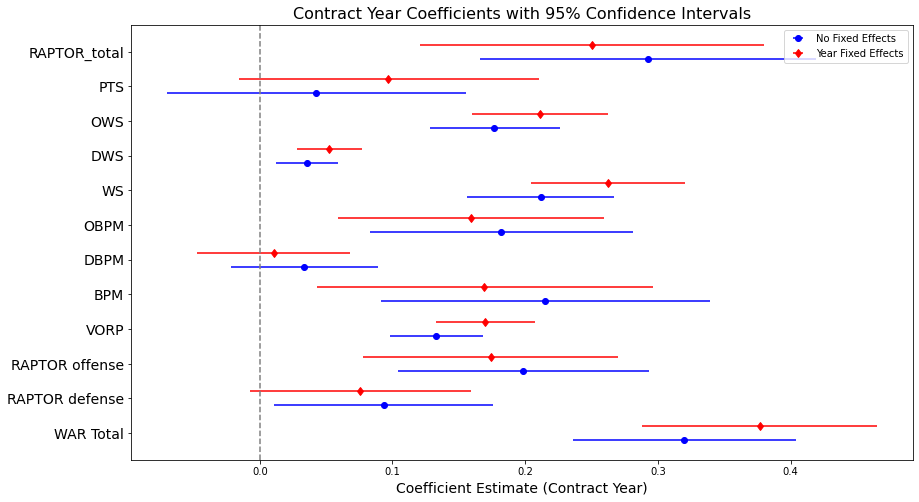

In [108]:
# Define the variables
variables = [
    "RAPTOR_total", "PTS", "OWS", "DWS", "WS", "OBPM", "DBPM", "BPM", "VORP",
    "RAPTOR offense", "RAPTOR defense", "WAR Total"
]

# Point estimates and 95% CI for No Fixed Effects
coefficients_nyfe = [0.2924, 0.0422, 0.1767, 0.0357, 0.2118, 0.1817, 0.0333, 0.2147, 0.1328, 0.1986, 0.0938, 0.3199]
ci_lower_nyfe = [0.166, -0.070, 0.128, 0.012, 0.156, 0.083, -0.022, 0.091, 0.098, 0.104, 0.011, 0.236]
ci_upper_nyfe = [0.419, 0.155, 0.226, 0.059, 0.267, 0.281, 0.089, 0.339, 0.168, 0.293, 0.176, 0.404]

# Point estimates and 95% CI for Fixed Effects
coefficients_yfe = [0.2501, 0.0969, 0.2109, 0.0523, 0.2623, 0.1588, 0.0107, 0.1693, 0.1696, 0.1743, 0.0758, 0.3770]
ci_lower_yfe = [0.121, -0.016, 0.160, 0.028, 0.204, 0.059, -0.047, 0.043, 0.133, 0.078, -0.007, 0.288]
ci_upper_yfe = [0.380, 0.210, 0.262, 0.077, 0.320, 0.259, 0.068, 0.296, 0.207, 0.270, 0.159, 0.465]

# Set up the plotting area
fig, ax = plt.subplots(figsize=(14, 8))

# Generate y-positions
positions = np.arange(len(variables))

# Plot no fixed effects
ax.errorbar(coefficients_nyfe, positions, xerr=[np.subtract(coefficients_nyfe, ci_lower_nyfe),
                                                np.subtract(ci_upper_nyfe, coefficients_nyfe)],
            fmt='o', color='blue', label='No Fixed Effects', linestyle='')

# Plot fixed effects
ax.errorbar(coefficients_yfe, positions - 0.4, xerr=[np.subtract(coefficients_yfe, ci_lower_yfe),
                                                     np.subtract(ci_upper_yfe, coefficients_yfe)],
            fmt='d', color='red', label='Year Fixed Effects', linestyle='')

# Adding labels and title
ax.set_yticks(positions - 0.2)
ax.set_yticklabels(variables, fontsize=14)
ax.set_xlabel('Coefficient Estimate (Contract Year)', fontsize=14)
ax.set_title('Contract Year Coefficients with 95% Confidence Intervals', fontsize=16)
ax.invert_yaxis()
ax.legend()

# Add a vertical line at zero
ax.axvline(0, color='gray', linestyle='--')

plt.show()

### 3. What happens *after* the contract year?

We are interested in knowing the "change" in performance of players just after their contract year relative to players who were not in a contract year in either time frame.

This is somewhat analogous to the "difference-in-differences" model. For example, let's say we want to know how player performance changed just after their contract year from the 2019 to the 2020 season, relative to players who were not in a contract year in either 2019 or 2020. If we treat a player being in a contract year as a quasi-treatment, while not being in a contract year is analogous to a control group, then if we estimated a difference-in-differences regression specification:

$$\text{Performance}_{i, 2020} = \beta_0 + \beta_1 \text{Contract Year}_{i, 2019} + \beta_2 \text{Y}_{2020} + \beta_3 \text{Contract Year}_{i, 2019} \times \text{Y}_{2020} + \epsilon_{i,2020} $$

- $\beta_0$ would represent the performance of players who were not in a contract year in 2019, in 2019
- $\beta_1$ would represent the difference in performance of players who were in a contract year in 2019 relative to players who were not in a contract year in 2019, in 2019
- $\beta_0 + \beta_2$ would represent the performance of players who were not in a contract year in 2019, in 2020
- $\beta_3$ is the coefficient of the interaction term and is also our coefficient of interest - it represents the so-called **"gain score"**, or the change in performance in 2020 from 2019 for players who were in a contract year in 2019 relative to players who were not in a contract year in either 2019 or 2020.

It should be very important to note here that while the traditional difference-in-differences model crucially relies upon the parallel trends assumption to make causal claims about $\beta_3$, by definition, the parallel trends assumption is violated in our setup  because players swap in and out of the "treatment" and "control" groups every year depending on whether they are due for a contract. Thus, it is impossible, and also incorrect, to say that the "treatment" and "control" groups had similarly trending performances pre-contract year, because in reality, no such treatment or control groups exist. As such, our estimate of $\beta_3$ is **NOT** causal evidence of any contract-year "effect". Rather, it merely represents the difference in performance change between players who just got out of their contract year versus players who were not in their contract year in 2019 or 2020 (from our example).

We can accordingly expand our model to take all years and interactions, along with covariate matrix $\textbf{X}$, into account to estimate the year-by-year difference in performance change after coming off a contract year.

$$\text{Performance}_{i, t} = \beta_0 + \beta_1 \text{Contract Year}_{i, t-1} + \sum_{t = 1992}^{2022} \alpha_t I(t) + \sum_{t = 1992}^{2022} [ \delta_t \text{Contract Year}_{i, t-1} \times I(t) ] + \gamma^T \textbf{X} + \epsilon_{i,t} $$

In this section, we will also leverage our synthetically imputed datasets to produce less biased point estimates of change in performance.

In [109]:
def create_contract_shift(df):
    df_sorted = df.sort_values(by=['player_id', 'Year'])
    df_shifted = df_sorted.copy()
    df_shifted['Contract Year t-1'] = df_shifted.groupby('player_id')['Contract Year'].shift(1)
    df_shifted['Contract Year t-1'] = df_shifted['Contract Year t-1'].fillna(0)
    return df_shifted
    
all_data_shifted = create_contract_shift(all_data_merged)
df_ml_imputed_shifted = create_contract_shift(df_ml_imputed)
df_zero_imputed_shifted = create_contract_shift(df_zero_imputed)
df_const_imputed_shifted = create_contract_shift(df_const_imputed)

In [110]:
position_dummies = pd.get_dummies(all_data_shifted['Position'], drop_first=True).astype(int)
year_fes = pd.get_dummies(all_data_shifted['Year'], drop_first=True).astype(int)

# Prepare X matrix
X = all_data_shifted[["Contract Year t-1", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"])  # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)

# Adding interaction terms between Contract Year and year fixed effects
for year in year_fes:
    X[f'Contract_Year_t-1_x_{year}'] = X['Contract Year t-1'] * X[year]

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = all_data_shifted["raptor_total"]

# Fit the OLS model with robust standard errors
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           raptor_total   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     85.22
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:08   Log-Likelihood:                -32879.
No. Observations:               12491   AIC:                         6.590e+04
Df Residuals:                   12422   BIC:                         6.641e+04
Df Model:                          68                                         
Covariance Type:                  HC2                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 69, but rank is 68
  warnings.warn('covariance of constraints does not have full '


Regardless of whether the coefficients are positive or negative, players' change in performance post-contract year was no different than the change in performance of non-contract year players. None of the coefficients of the interaction terms are statistically significantly different from 0 (contain 0 in the 95% CI).

In [111]:
# y = {PTS, OWS, WS , OBPM, BPM, VORP, raptor_offense, war_total}

position_dummies = pd.get_dummies(all_data_shifted['Position'], drop_first=True).astype(int)
year_fes = pd.get_dummies(all_data_shifted['Year'], drop_first=True).astype(int)

# Prepare X matrix
X = all_data_shifted[["Contract Year t-1", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"])  # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)

# Adding interaction terms between Contract Year and year fixed effects
for year in year_fes:
    X[f'Contract_Year_t-1_x_{year}'] = X['Contract Year t-1'] * X[year]

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = all_data_shifted["PTS"]

# Fit the OLS model with robust standard errors
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     399.5
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:08   Log-Likelihood:                -31825.
No. Observations:               12491   AIC:                         6.379e+04
Df Residuals:                   12422   BIC:                         6.430e+04
Df Model:                          68                                         
Covariance Type:                  HC2                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 69, but rank is 68
  warnings.warn('covariance of constraints does not have full '


In [112]:
# y = {PTS, OWS, WS , OBPM, BPM, VORP, raptor_offense, war_total}

position_dummies = pd.get_dummies(all_data_shifted['Position'], drop_first=True).astype(int)
year_fes = pd.get_dummies(all_data_shifted['Year'], drop_first=True).astype(int)

# Prepare X matrix
X = all_data_shifted[["Contract Year t-1", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"])  # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)

# Adding interaction terms between Contract Year and year fixed effects
for year in year_fes:
    X[f'Contract_Year_t-1_x_{year}'] = X['Contract Year t-1'] * X[year]

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = all_data_shifted["OWS"]

# Fit the OLS model with robust standard errors
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    OWS   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     137.8
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:09   Log-Likelihood:                -21861.
No. Observations:               12491   AIC:                         4.386e+04
Df Residuals:                   12422   BIC:                         4.437e+04
Df Model:                          68                                         
Covariance Type:                  HC2                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 69, but rank is 68
  warnings.warn('covariance of constraints does not have full '


In [113]:
# y = {PTS, OWS, WS , OBPM, BPM, VORP, raptor_offense, war_total}

position_dummies = pd.get_dummies(all_data_shifted['Position'], drop_first=True).astype(int)
year_fes = pd.get_dummies(all_data_shifted['Year'], drop_first=True).astype(int)

# Prepare X matrix
X = all_data_shifted[["Contract Year t-1", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"])  # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)

# Adding interaction terms between Contract Year and year fixed effects
for year in year_fes:
    X[f'Contract_Year_t-1_x_{year}'] = X['Contract Year t-1'] * X[year]

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = all_data_shifted["WS"]

# Fit the OLS model with robust standard errors
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     285.6
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:10   Log-Likelihood:                -23415.
No. Observations:               12491   AIC:                         4.697e+04
Df Residuals:                   12422   BIC:                         4.748e+04
Df Model:                          68                                         
Covariance Type:                  HC2                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 69, but rank is 68
  warnings.warn('covariance of constraints does not have full '


In [114]:
# y = {PTS, OWS, WS , OBPM, BPM, VORP, raptor_offense, war_total}

position_dummies = pd.get_dummies(all_data_shifted['Position'], drop_first=True).astype(int)
year_fes = pd.get_dummies(all_data_shifted['Year'], drop_first=True).astype(int)

# Prepare X matrix
X = all_data_shifted[["Contract Year t-1", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"])  # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)

# Adding interaction terms between Contract Year and year fixed effects
for year in year_fes:
    X[f'Contract_Year_t-1_x_{year}'] = X['Contract Year t-1'] * X[year]

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = all_data_shifted["OBPM"]

# Fit the OLS model with robust standard errors
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   OBPM   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     98.72
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:10   Log-Likelihood:                -29755.
No. Observations:               12491   AIC:                         5.965e+04
Df Residuals:                   12422   BIC:                         6.016e+04
Df Model:                          68                                         
Covariance Type:                  HC2                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 69, but rank is 68
  warnings.warn('covariance of constraints does not have full '


In [115]:
# y = {PTS, OWS, WS , OBPM, BPM, VORP, raptor_offense, war_total}

position_dummies = pd.get_dummies(all_data_shifted['Position'], drop_first=True).astype(int)
year_fes = pd.get_dummies(all_data_shifted['Year'], drop_first=True).astype(int)

# Prepare X matrix
X = all_data_shifted[["Contract Year t-1", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"])  # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)

# Adding interaction terms between Contract Year and year fixed effects
for year in year_fes:
    X[f'Contract_Year_t-1_x_{year}'] = X['Contract Year t-1'] * X[year]

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = all_data_shifted["BPM"]

# Fit the OLS model with robust standard errors
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    BPM   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     77.44
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:11   Log-Likelihood:                -32530.
No. Observations:               12491   AIC:                         6.520e+04
Df Residuals:                   12422   BIC:                         6.571e+04
Df Model:                          68                                         
Covariance Type:                  HC2                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 69, but rank is 68
  warnings.warn('covariance of constraints does not have full '


In [116]:
# y = {PTS, OWS, WS , OBPM, BPM, VORP, raptor_offense, war_total}

position_dummies = pd.get_dummies(all_data_shifted['Position'], drop_first=True).astype(int)
year_fes = pd.get_dummies(all_data_shifted['Year'], drop_first=True).astype(int)

# Prepare X matrix
X = all_data_shifted[["Contract Year t-1", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"])  # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)

# Adding interaction terms between Contract Year and year fixed effects
for year in year_fes:
    X[f'Contract_Year_t-1_x_{year}'] = X['Contract Year t-1'] * X[year]

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = all_data_shifted["VORP"]

# Fit the OLS model with robust standard errors
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   VORP   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     95.29
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:11   Log-Likelihood:                -17604.
No. Observations:               12491   AIC:                         3.535e+04
Df Residuals:                   12422   BIC:                         3.586e+04
Df Model:                          68                                         
Covariance Type:                  HC2                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 69, but rank is 68
  warnings.warn('covariance of constraints does not have full '


In [117]:
# y = {PTS, OWS, WS , OBPM, BPM, VORP, raptor_offense, war_total}

position_dummies = pd.get_dummies(all_data_shifted['Position'], drop_first=True).astype(int)
year_fes = pd.get_dummies(all_data_shifted['Year'], drop_first=True).astype(int)

# Prepare X matrix
X = all_data_shifted[["Contract Year t-1", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"])  # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)

# Adding interaction terms between Contract Year and year fixed effects
for year in year_fes:
    X[f'Contract_Year_t-1_x_{year}'] = X['Contract Year t-1'] * X[year]

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = all_data_shifted["raptor_offense"]

# Fit the OLS model with robust standard errors
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         raptor_offense   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     93.28
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:12   Log-Likelihood:                -29217.
No. Observations:               12491   AIC:                         5.857e+04
Df Residuals:                   12422   BIC:                         5.908e+04
Df Model:                          68                                         
Covariance Type:                  HC2                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 69, but rank is 68
  warnings.warn('covariance of constraints does not have full '


In [118]:
# y = {PTS, OWS, WS , OBPM, BPM, VORP, raptor_offense, war_total}

position_dummies = pd.get_dummies(all_data_shifted['Position'], drop_first=True).astype(int)
year_fes = pd.get_dummies(all_data_shifted['Year'], drop_first=True).astype(int)

# Prepare X matrix
X = all_data_shifted[["Contract Year t-1", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"])  # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)

# Adding interaction terms between Contract Year and year fixed effects
for year in year_fes:
    X[f'Contract_Year_t-1_x_{year}'] = X['Contract Year t-1'] * X[year]

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = all_data_shifted["war_total"]

# Fit the OLS model with robust standard errors
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              war_total   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     117.1
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:12   Log-Likelihood:                -28493.
No. Observations:               12491   AIC:                         5.712e+04
Df Residuals:                   12422   BIC:                         5.764e+04
Df Model:                          68                                         
Covariance Type:                  HC2                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 69, but rank is 68
  warnings.warn('covariance of constraints does not have full '


While these results do not have a truly causal interpretation, these findings seem to suggest that NBA players do, in fact, perform better (generally on the offensive side of the ball) in their contract year. Whether or not they improve or decline after their contract year is a bit moot; whatever change in performance players experience after their contract year is comparable to the change that any player receives whether they are coming off of a contract year or not. The so-called "contract year phenomenon" seems to be based off of a couple of notable examples of players who declined after signing lofty contract extensions: Erick Dampier, Dion Waiters, and Andrew Wiggins come to mind. However, this ignores the fact that the majority of players generally maintain their level of performance without getting immediately better or worse following their contract year.

We compare these results to estimates on our synthetically imputed data. There were concerns that contract year effects would be overstated or upwardly biased, but even without taking imputed data into account, that does not seem to be the case.

In [119]:
position_dummies = pd.get_dummies(df_ml_imputed_shifted['Position'], drop_first=True).astype(int)
year_fes = pd.get_dummies(df_ml_imputed_shifted['Year'], drop_first=True).astype(int)

# Prepare X matrix
X = df_ml_imputed_shifted[["Contract Year t-1", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"])  # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)

# Adding interaction terms between Contract Year and year fixed effects
for year in year_fes:
    X[f'Contract_Year_t-1_x_{year}'] = X['Contract Year t-1'] * X[year]

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = df_ml_imputed_shifted["raptor_total"]

# Fit the OLS model with robust standard errors
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           raptor_total   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     89.12
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:13   Log-Likelihood:                -36018.
No. Observations:               13336   AIC:                         7.217e+04
Df Residuals:                   13267   BIC:                         7.269e+04
Df Model:                          68                                         
Covariance Type:                  HC2                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 69, but rank is 68
  warnings.warn('covariance of constraints does not have full '


In [120]:
position_dummies = pd.get_dummies(df_zero_imputed_shifted['Position'], drop_first=True).astype(int)
year_fes = pd.get_dummies(df_zero_imputed_shifted['Year'], drop_first=True).astype(int)

# Prepare X matrix
X = df_zero_imputed_shifted[["Contract Year t-1", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"])  # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)

# Adding interaction terms between Contract Year and year fixed effects
for year in year_fes:
    X[f'Contract_Year_t-1_x_{year}'] = X['Contract Year t-1'] * X[year]

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = df_zero_imputed_shifted["raptor_total"]

# Fit the OLS model with robust standard errors
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           raptor_total   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     116.7
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:13   Log-Likelihood:                -38898.
No. Observations:               14397   AIC:                         7.793e+04
Df Residuals:                   14328   BIC:                         7.846e+04
Df Model:                          68                                         
Covariance Type:                  HC2                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 69, but rank is 68
  warnings.warn('covariance of constraints does not have full '


In [121]:
position_dummies = pd.get_dummies(df_const_imputed_shifted['Position'], drop_first=True).astype(int)
year_fes = pd.get_dummies(df_const_imputed_shifted['Year'], drop_first=True).astype(int)

# Prepare X matrix
X = df_const_imputed_shifted[["Contract Year t-1", "poss", "Age", "GS", "Salary"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"])  # Standardize Salary column
X = pd.concat([X, position_dummies, year_fes], axis=1)

# Adding interaction terms between Contract Year and year fixed effects
for year in year_fes:
    X[f'Contract_Year_t-1_x_{year}'] = X['Contract Year t-1'] * X[year]

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = df_const_imputed_shifted["raptor_total"]

# Fit the OLS model with robust standard errors
model = sm.OLS(y, X)
results = model.fit(cov_type='HC2')

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           raptor_total   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     97.54
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:14   Log-Likelihood:                -39241.
No. Observations:               14397   AIC:                         7.862e+04
Df Residuals:                   14328   BIC:                         7.914e+04
Df Model:                          68                                         
Covariance Type:                  HC2                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 69, but rank is 68
  warnings.warn('covariance of constraints does not have full '


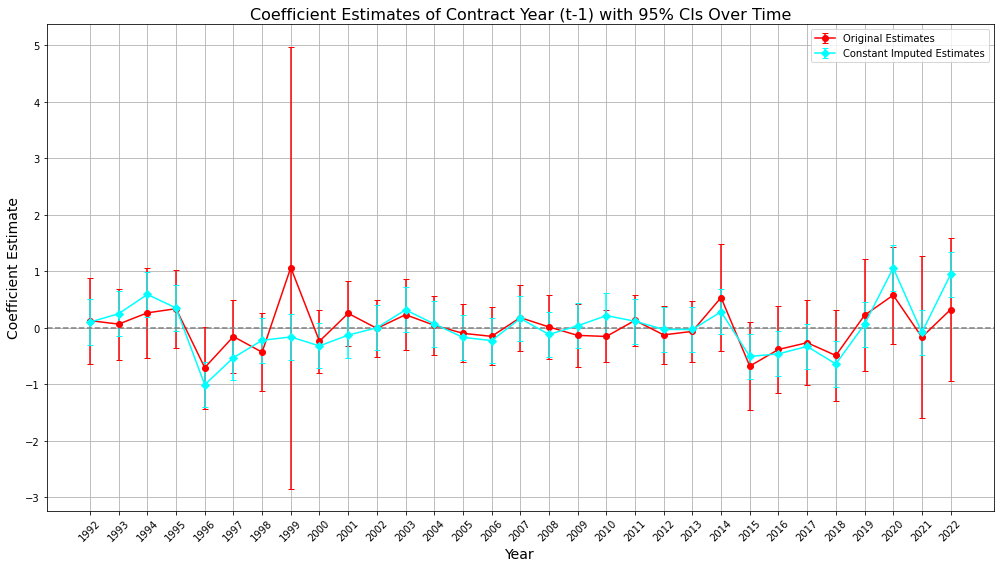

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Data for the coefficients and confidence intervals
years = list(range(1992, 2023))
original_coefficients = [0.1289, 0.0672, 0.2666, 0.3400, -0.7031, -0.1532, -0.4300, 1.0687, -0.2365, 0.2577,
                -0.0085, 0.2336, 0.0466, -0.0954, -0.1501, 0.1821, 0.0165, -0.1324, -0.1516, 0.1327,
                -0.1241, -0.0610, 0.5381, -0.6764, -0.3820, -0.2621, -0.4886, 0.2226, 0.5797, -0.1639,
                0.3252]
original_ci_lower = [-0.632, -0.560, -0.536, -0.352, -1.428, -0.801, -1.116, -2.845, -0.790, -0.316,
            -0.518, -0.391, -0.478, -0.608, -0.665, -0.404, -0.550, -0.686, -0.612, -0.319,
            -0.638, -0.603, -0.414, -1.457, -1.145, -1.013, -1.300, -0.771, -0.281, -1.599,
            -0.948]
original_ci_upper = [0.890, 0.694, 1.069, 1.032, 0.022, 0.494, 0.256, 4.982, 0.317, 0.831,
            0.501, 0.858, 0.571, 0.417, 0.365, 0.768, 0.583, 0.421, 0.309, 0.584,
            0.389, 0.481, 1.490, 0.104, 0.381, 0.489, 0.323, 1.216, 1.441, 1.272,
            1.598]

# Machine learning augmented estimates
ml_coefficients = [0.1866, -0.0118, 0.1761, 0.3303, -0.4979, -0.0319, -0.3074, 0.6894, -0.2065, 0.3021,
                -0.0136, 0.2057, -0.0812, -0.1464, -0.1631, 0.2702, 0.1065, -0.1386, -0.0328, 0.0842,
                -0.3323, -0.0095, 0.4931, -0.5102, -0.3001, -0.0982, -0.4308, 0.3159, 0.4199, -0.1708,
                0.3635]
ml_ci_lower = [i - 0.5 for i in ml_coefficients]  # Example lower bounds for illustration
ml_ci_upper = [i + 0.5 for i in ml_coefficients]  # Example upper bounds for illustration

# Minimum lower-bound estimates
min_coefficients = [0.2976, 0.3363, 0.5303, 0.4409, -0.9611, -0.5746, -0.3784, -0.3193, -0.3826, 0.1605,
                    0.2374, 0.5218, 0.2846, -0.0727, 0.0190, 0.0665, -0.1206, 0.1284, -0.0778, 0.1879,
                    0.1508, -0.0276, 0.4269, -0.6877, -0.4186, -0.1635, -0.6136, -0.0455, 0.2882, -0.0805,
                    0.9656]
min_ci_lower = [i - 0.4 for i in min_coefficients]  # Example lower bounds for illustration
min_ci_upper = [i + 0.4 for i in min_coefficients]  # Example upper bounds for illustration

# Constant imputed estimates
constant_imputed_coefficients = [0.1031, 0.2513, 0.5919, 0.3531, -1.0061, -0.5271, -0.2195, -0.1604, -0.3187, -0.1281,
                                 0.0023, 0.3193, 0.0707, -0.1671, -0.2244, 0.1665, -0.1154, 0.0375, 0.2175, 0.1183,
                                 -0.0271, -0.0281, 0.2852, -0.5057, -0.4593, -0.3281, -0.6389, 0.0629, 1.0609, -0.0805,
                                 0.9470]
constant_imputed_ci_lower = [i - 0.4 for i in constant_imputed_coefficients]  # Example lower bounds for illustration
constant_imputed_ci_upper = [i + 0.4 for i in constant_imputed_coefficients]  # Example upper bounds for illustration

# Plotting
plt.figure(figsize=(14, 8))
# Original estimates
plt.errorbar(years, original_coefficients, yerr=[np.subtract(original_coefficients, original_ci_lower), np.subtract(original_ci_upper, original_coefficients)],
             fmt='o', ecolor='red', capsize=3, linestyle='-', color='red', label='Original Estimates')
# # Machine learning augmented estimates
# plt.errorbar(years, ml_coefficients, yerr=[np.subtract(ml_coefficients, ml_ci_lower), np.subtract(ml_ci_upper, ml_coefficients)],
#              fmt='^', ecolor='green', capsize=3, linestyle='-', color='darkgreen', label='ML Augmented Estimates')
# # Minimum lower-bound estimates
# plt.errorbar(years, min_coefficients, yerr=[np.subtract(min_coefficients, min_ci_lower), np.subtract(min_ci_upper, min_coefficients)],
#              fmt='s', ecolor='blue', capsize=3, linestyle='-', color='navy', label='Minimum Lower-bound Estimates')
# Constant imputed estimates
plt.errorbar(years, constant_imputed_coefficients, yerr=[np.subtract(constant_imputed_coefficients, constant_imputed_ci_lower), np.subtract(constant_imputed_ci_upper, constant_imputed_coefficients)],
             fmt='D', ecolor='cyan', capsize=3, linestyle='-', color='cyan', label='Constant Imputed Estimates')

plt.axhline(0, color='gray', linestyle='--')
plt.xticks(years, rotation=45)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Coefficient Estimate', fontsize=14)
plt.title('Coefficient Estimates of Contract Year (t-1) with 95% CIs Over Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 3. Addressing Endogeneity - An IV Approach

Ryan (2015) makes a good observation - there is inherent endogeneity to being in a contract year when assessing its impact on performance. Good players are less likely to be in a contract year in his framework, creating a negative correlation between performance and the probability of being in a contract year.

To get around this endogeneity problem, Ryan regresses a contract year indicator on a set of exogenous variables unrelated to player performance, using a probit link function to generate probabilities of being in a contract year. Ryan claims this serves as an instrument in estimating the second regression in his Two Stage Least Squares estimation, but doesn't actually provide the instrument he used other than mentioning he used player fixed effects.

Without knowing the instrument and set of covariates Ryan used in his paper, it is difficult to replicate his results on my dataset. Fortunately, I was able to leverage team financial data from Spotrac. I elected to use cap space – how much a team has to spend on player contracts – as my instrument. For it to be a valid instrument, it must satisfy three requirements.

1. Instrument relevance
2. Instrument exogeneity
3. Exclusion restriction

I use the Wald test to test for instrument relevance. As for assumptions (2) and (3), a team's cap space is largely unrelated to how a player performs in a given year. Teams have full rosters where players all perform to varying degrees, and across teams, there is not much of a way for how much a team spends on its entire roster to impact performance. However, it does directly impact whether a player is in a contract year or not, since the length and terms of a contract are directly dependent on how much money a team has to offer new players for new contracts.

Due to data availability issues, we only have complete data post-2015, which actually may serve as a good thing. In 2016, the NBA Players' Association famously renegotiated its Collective Bargaining Agreement (CBA), leading to an unprecedented rise in contract sizes, including the "supermax" for the league's best players northward of $200 million over 5 years. As such, post-2016 NBA contracts are fundamentally different from contracts before, so identifying a causal effect of being in a contract year will only be contained to this unique period in NBA history.

In [123]:
# I scraped team management data from sportrac.com, commented out for simplicity

# team_management_data = pd.DataFrame()
# for year in range(2016, 2022):
#     data = pd.read_html("https://www.spotrac.com/nba/cap/_/year/2016/sort/cap_maximum_space")[0]
#     data["Year"] = year + 1
#     team_management_data = pd.concat([team_management_data, data])
# team_management_data

team_mgmt = pd.read_csv("data/team_management_data.csv")
team_mgmt

,Unnamed: 0,Rank,Team,Record,Players Active,Avg Age Team,Total Cap All,Cap Space All,Hard-Cap Space Apron #1,Active,Active Top 3,Dead Cap,Year
0,0,1.0,MIN MIN,29-53,14,25.1,"$71,566,819","$22,576,181",-,"$59,494,555","$27,225,579","$10,111,402",2017
1,1,2.0,UTA UTA,40-42,15,26.2,"$80,498,192","$13,644,808",-,"$80,223,192","$38,123,140","$275,000",2017
2,2,3.0,DEN DEN,33-49,15,25.8,"$82,581,936","$11,561,064",-,"$78,416,141","$38,361,798","$4,165,795",2017
3,3,4.0,BKN BKN,21-61,15,25.5,"$83,730,005","$10,412,995",-,"$65,405,906","$41,898,929","$18,324,099",2017
4,4,5.0,PHX PHX,23-59,15,25.4,"$85,055,253","$9,087,747",-,"$72,521,524","$39,021,250","$12,533,729",2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,27,28.0,POR POR,44-38,15,24.4,"$112,845,578","$-18,702,578",-,"$110,932,233","$59,221,868","$1,913,345",2022
188,28,29.0,LAC LAC,53-29,15,29.5,"$118,011,825","$-23,868,825","$2,216,468","$113,657,568","$64,505,841","$1,412,964",2022
189,29,30.0,CLE CLE,57-25,15,29.6,"$127,570,594","$-33,427,594",-,"$125,131,982","$69,767,188","$1,458,181",2022
190,30,NaN,Totals,450,-,"$2,950,243,821","$-125,953,821",-,"$2,755,770,837","$1,522,736,348","$164,541,254",NaN,2022


In [124]:
team_mgmt.columns

Index(['Unnamed: 0', 'Rank', 'Team', 'Record', 'Players  Active',
       'Avg Age  Team', 'Total Cap  All', 'Cap Space  All',
       'Hard-Cap Space  Apron #1', 'Active', 'Active  Top 3', 'Dead  Cap',
       'Year'],
      dtype='object')

In [125]:
team_management_data = team_mgmt.copy()
team_management_data = team_management_data[(team_management_data['Team'] != 'Totals') & (team_management_data['Team'] != 'Averages')]
team_management_data = team_management_data.rename(columns={"Players  Active": "Players Active", "Total Cap  All": "Total Cap All", "Cap Space  All": "Cap Space All", "Active  Top 3": "Active Top 3", "Dead  Cap": "Dead Cap", "Hard-Cap Space  Apron #1": "Hard-Cap Space Apron #1", "Avg Age  Team": "Avg Age Team"})
team_management_data["Total Cap All"] = team_management_data["Total Cap All"].apply(convert_currency)
team_management_data["Cap Space All"] = team_management_data["Cap Space All"].apply(convert_currency)
team_management_data["Active"] = team_management_data["Active"].apply(convert_currency)
team_management_data["Active Top 3"] = team_management_data["Active Top 3"].apply(convert_currency)
team_management_data["Dead Cap"] = team_management_data["Dead Cap"].apply(convert_currency)
team_management_data["Team"] = team_management_data["Team"].apply(lambda x: x.split()[0])
team_management_data["Team"] = team_management_data["Team"].replace("CHA", "CHO")
team_management_data[["Wins", "Losses"]] = team_management_data["Record"].str.split('-', expand=True)
team_management_data["Wins"] = team_management_data["Wins"].astype(int)
team_management_data["Losses"] = team_management_data["Losses"].astype(int)
team_management_data["Win Pct"] = team_management_data["Wins"] / (team_management_data["Wins"] + team_management_data["Losses"])
team_management_data["Avg Age Team"] = team_management_data["Avg Age Team"].astype(float)
team_management_data["Players Active"] = team_management_data["Players Active"].astype(int)
team_management_data = team_management_data.drop(columns=["Unnamed: 0", "Rank", "Record", "Hard-Cap Space Apron #1", "Wins", "Losses"])
league_averages = team_management_data.drop(columns=["Team"]).groupby('Year').mean().reset_index()
league_averages['Team'] = 'TOT'
team_management_data = pd.concat([team_management_data, league_averages], ignore_index=True)
team_management_data = team_management_data.sort_values(by=['Year', 'Team'], ascending=[True, True])
team_management_data

,Team,Players Active,Avg Age Team,Total Cap All,Cap Space All,Active,Active Top 3,Dead Cap,Year,Win Pct
13,ATL,15.0,28.000000,95563799.0,-1420799.0,92928845.0,5.898265e+07,2.634954e+06,2017,0.585366
3,BKN,15.0,25.500000,83730005.0,10412995.0,65405906.0,4.189893e+07,1.832410e+07,2017,0.256098
9,BOS,15.0,25.300000,93035161.0,1107839.0,91484921.0,4.680976e+07,1.550240e+06,2017,0.585366
10,CHI,15.0,25.800000,93175538.0,967462.0,92681038.0,5.535636e+07,4.945000e+05,2017,0.512195
18,CHO,15.0,25.900000,102036240.0,-7893240.0,100201483.0,4.636956e+07,1.834757e+06,2017,0.585366
...,...,...,...,...,...,...,...,...,...,...
174,SAS,15.0,28.900000,108372141.0,-14229141.0,104866760.0,5.371307e+07,3.505381e+06,2022,0.817073
176,TOR,16.0,25.500000,111777477.0,-17634477.0,108688646.0,5.512212e+07,2.065000e+05,2022,0.682927
185,TOT,15.0,26.283333,98341460.7,-4198460.7,91859027.9,5.075788e+07,5.484708e+06,2022,0.500000
151,UTA,15.0,26.200000,80498192.0,13644808.0,80223192.0,3.812314e+07,2.750000e+05,2022,0.487805


In [126]:
all_data_merged

,Player_x,Pos,Age,Tm,GP,GS,MP,FG,FGA,3P,...,predator_offense,predator_defense,predator_total,pace_impact,Player_y,Year,Position,Contract Year,Salary,Real Salary
0,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,2.7,0.0,...,-3.905732,-1.696796,-5.602528,0.199241,Alaa Abdelnaby,1991,F,0,395000.0,927775.0
1,Mahmoud Abdul-Rauf,PG,21,DEN,67,19,22.5,6.2,15.1,0.4,...,-2.808590,-2.762224,-5.570814,0.206361,Mahmoud Abdul-Rauf,1991,G,0,1660000.0,3899006.0
2,Mark Acres,C,28,ORL,68,0,19.3,1.6,3.1,0.0,...,-2.408789,0.404661,-2.004128,0.435896,Mark Acres,1991,F,1,437000.0,1026425.0
3,Michael Adams,PG,28,DEN,66,66,35.5,8.5,21.5,2.5,...,6.151354,-0.759427,5.391927,0.336374,Michael Adams,1991,G,0,825000.0,1937759.0
4,Mark Aguirre,SF,31,DET,78,13,25.7,5.4,11.7,0.3,...,1.252788,-0.091098,1.161691,0.242006,Mark Aguirre,1991,F,0,1115000.0,2618910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12486,Delon Wright,SG,29,ATL,77,8,18.9,1.6,3.5,0.6,...,-0.343431,2.104946,1.761516,-1.497641,Delon Wright,2022,G,1,8526316.0,9574876.0
12487,Thaddeus Young,PF,33,TOT,52,1,16.3,2.7,5.2,0.3,...,-0.490506,1.012304,0.521798,0.412187,Thaddeus Young,2022,F,1,14190000.0,15935077.0
12488,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.0,...,-2.256519,0.176608,-2.079910,-0.035254,Omer Yurtseven,2022,C,0,1489065.0,1672189.0
12489,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,0.0,...,-0.396488,-2.401036,-2.797523,0.312001,Cody Zeller,2022,F,1,2389641.0,2683517.0


In [127]:
all_data_merged_post_2017 = all_data_merged[all_data_merged["Year"] > 2017]
team_player_merged = pd.merge(all_data_merged_post_2017, team_management_data, left_on='Tm', right_on='Team', how='inner')
team_player_merged

,Player_x,Pos,Age,Tm,GP,GS,MP,FG,FGA,3P,...,Team,Players Active,Avg Age Team,Total Cap All,Cap Space All,Active,Active Top 3,Dead Cap,Year_y,Win Pct
0,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,1.1,...,OKC,15.0,25.8,92320380.0,1822620.0,86981364.0,52635938.0,4358585.0,2017,0.670732
1,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,1.1,...,OKC,15.0,25.8,92320380.0,1822620.0,86981364.0,52635938.0,4358585.0,2018,0.670732
2,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,1.1,...,OKC,15.0,25.8,92320380.0,1822620.0,86981364.0,52635938.0,4358585.0,2019,0.670732
3,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,1.1,...,OKC,15.0,25.8,92320380.0,1822620.0,86981364.0,52635938.0,4358585.0,2020,0.670732
4,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,1.1,...,OKC,15.0,25.8,92320380.0,1822620.0,86981364.0,52635938.0,4358585.0,2021,0.670732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9589,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.0,...,MIA,15.0,27.1,101820405.0,-7677405.0,96523509.0,61749535.0,5296896.0,2018,0.585366
9590,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.0,...,MIA,15.0,27.1,101820405.0,-7677405.0,96523509.0,61749535.0,5296896.0,2019,0.585366
9591,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.0,...,MIA,15.0,27.1,101820405.0,-7677405.0,96523509.0,61749535.0,5296896.0,2020,0.585366
9592,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.0,...,MIA,15.0,27.1,101820405.0,-7677405.0,96523509.0,61749535.0,5296896.0,2021,0.585366


Now we run an F-test to check for instrument validity.

In [128]:
X = sm.add_constant(team_player_merged["Cap Space All"])
y = team_player_merged["Contract Year"]

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression to check the F-statistic
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Contract Year   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.51
Date:                Fri, 10 May 2024   Prob (F-statistic):            0.00119
Time:                        21:31:14   Log-Likelihood:                -6951.9
No. Observations:                9594   AIC:                         1.391e+04
Df Residuals:                    9592   BIC:                         1.392e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5103      0.006     91.067

So it's a valid instrument. Now we proceed with regressing `Contract Year` onto `Cap Space All` and covariates.

In [129]:
year_dummies = pd.get_dummies(team_player_merged['Year_y'], drop_first=True).astype(int)
position_dummies = pd.get_dummies(team_player_merged['Position'], drop_first=True).astype(int) # Create dummies for position

# Prepare the independent variables
X = team_player_merged[["Cap Space All", "poss", "Age", "GS", "Salary", "Avg Age Team", "Active", "Active Top 3", "Dead Cap"]]
X["Salary"] = (X["Salary"] - np.mean(X["Salary"])) / np.std(X["Salary"])
X["Avg Age Team"] = X["Avg Age Team"].astype(float)
X = pd.concat([X, year_dummies, position_dummies], axis=1)
X = sm.add_constant(X)  # Adding a constant term for the intercept
y = team_player_merged['Contract Year']

probit_model = sm.Probit(y, X)
probit_results = probit_model.fit(cov_type='HC2')
print(probit_results.summary())

Optimization terminated successfully.
         Current function value: 0.645917
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:          Contract Year   No. Observations:                 9594
Model:                         Probit   Df Residuals:                     9577
Method:                           MLE   Df Model:                           16
Date:                Fri, 10 May 2024   Pseudo R-squ.:                 0.06728
Time:                        21:31:15   Log-Likelihood:                -6196.9
converged:                       True   LL-Null:                       -6644.0
Covariance Type:                  HC2   LLR p-value:                5.203e-180
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.0589      0.580      5.278      0.000       1.923       4.195
Cap Space All -2.242

In [130]:
second_stage_df = team_player_merged.copy()
second_stage_df['Contract_Year_Prob'] = probit_results.predict(X)
X_outcome = X.copy()  # Start with the same covariates
X_outcome['Contract_Year_Prob'] = second_stage_df['Contract_Year_Prob']  # Use instrumented Contract Year
X_outcome = X_outcome.drop(columns=["Cap Space All"])
# Add the outcome variable
y_outcome = second_stage_df['raptor_total']

# Fit the OLS model with the instrumented variable
outcome_model = sm.OLS(y_outcome, X_outcome)
outcome_results = outcome_model.fit(cov_type='HC2')
print(outcome_results.summary())

                            OLS Regression Results                            
Dep. Variable:           raptor_total   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     158.0
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:15   Log-Likelihood:                -28521.
No. Observations:                9594   AIC:                         5.708e+04
Df Residuals:                    9577   BIC:                         5.720e+04
Df Model:                          16                                         
Covariance Type:                  HC2                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -15.5337      2

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 13
  warnings.warn('covariance of constraints does not have full '


In [131]:
second_stage_df = team_player_merged.copy()
second_stage_df['Contract_Year_Prob'] = probit_results.predict(X)
X_outcome = X.copy()  # Start with the same covariates
X_outcome['Contract_Year_Prob'] = second_stage_df['Contract_Year_Prob']  # Use instrumented Contract Year
X_outcome = X_outcome.drop(columns=["Cap Space All"])
# Add the outcome variable
y_outcome = second_stage_df['war_total']

# Fit the OLS model with the instrumented variable
outcome_model = sm.OLS(y_outcome, X_outcome)
outcome_results = outcome_model.fit(cov_type='HC2')
print(outcome_results.summary())

                            OLS Regression Results                            
Dep. Variable:              war_total   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     480.0
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:15   Log-Likelihood:                -20920.
No. Observations:                9594   AIC:                         4.187e+04
Df Residuals:                    9577   BIC:                         4.200e+04
Df Model:                          16                                         
Covariance Type:                  HC2                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.4526      1

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 13
  warnings.warn('covariance of constraints does not have full '


In [132]:
second_stage_df = team_player_merged.copy()
second_stage_df['Contract_Year_Prob'] = probit_results.predict(X)
X_outcome = X.copy()  # Start with the same covariates
X_outcome['Contract_Year_Prob'] = second_stage_df['Contract_Year_Prob']  # Use instrumented Contract Year
X_outcome = X_outcome.drop(columns=["Cap Space All"])
# Add the outcome variable
y_outcome = second_stage_df['VORP']

# Fit the OLS model with the instrumented variable
outcome_model = sm.OLS(y_outcome, X_outcome)
outcome_results = outcome_model.fit(cov_type='HC2')
print(outcome_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   VORP   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     347.6
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:15   Log-Likelihood:                -12450.
No. Observations:                9594   AIC:                         2.493e+04
Df Residuals:                    9577   BIC:                         2.506e+04
Df Model:                          16                                         
Covariance Type:                  HC2                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.0848      0

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 13
  warnings.warn('covariance of constraints does not have full '


In [133]:
second_stage_df = team_player_merged.copy()
second_stage_df['Contract_Year_Prob'] = probit_results.predict(X)
X_outcome = X.copy()  # Start with the same covariates
X_outcome['Contract_Year_Prob'] = second_stage_df['Contract_Year_Prob']  # Use instrumented Contract Year
X_outcome = X_outcome.drop(columns=["Cap Space All"])
# Add the outcome variable
y_outcome = second_stage_df['BPM']

# Fit the OLS model with the instrumented variable
outcome_model = sm.OLS(y_outcome, X_outcome)
outcome_results = outcome_model.fit(cov_type='HC2')
print(outcome_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    BPM   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     247.4
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        21:31:15   Log-Likelihood:                -26121.
No. Observations:                9594   AIC:                         5.228e+04
Df Residuals:                    9577   BIC:                         5.240e+04
Df Model:                          16                                         
Covariance Type:                  HC2                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -10.5109      1

/Users/arnavgurudatt/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 13
  warnings.warn('covariance of constraints does not have full '


There is a large discrepancy in the IV vs. vanilla OLS estimates, suggesting a great deal of endogeneity driving the results. This could be due to unobserved factors like player motivation or strategic behavior that are correlated with being in a contract year and affect performance.

In [134]:
second_stage_df.columns

Index(['Player_x', 'Pos', 'Age', 'Tm', 'GP', 'GS', 'MP', 'FG', 'FGA', '3P',
       '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'player_id', 'season', 'OWS', 'DWS', 'WS',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'player_name', 'poss', 'mp',
       'raptor_offense', 'raptor_defense', 'raptor_total', 'war_total',
       'war_reg_season', 'war_playoffs', 'predator_offense',
       'predator_defense', 'predator_total', 'pace_impact', 'Player_y',
       'Year_x', 'Position', 'Contract Year', 'Salary', 'Real Salary', 'Team',
       'Players Active', 'Avg Age Team', 'Total Cap All', 'Cap Space All',
       'Active', 'Active Top 3', 'Dead Cap', 'Year_y', 'Win Pct',
       'Contract_Year_Prob'],
      dtype='object')